In [1]:
import torch
import os
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import pickle
import warnings
import pandas as pd
from scipy import ndimage as ndi
warnings.filterwarnings("ignore")

In [2]:
from torchvision import models
from torchsummary import summary
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_id = [0] # only modify if you machine has more than one GPU card

In [5]:
import skimage
SPECIM = '/home/makam0a/Dropbox/Pixeltra/Datasets/Demo1/'
realfake_label = pd.read_csv(SPECIM + "NPY_data/" + 'realfake_label.csv')
realfake_label['folder'] = 'realfakelabel/'
real_label = pd.read_csv(SPECIM + "NPY_data/" + 'real_label.csv')
real_label['folder'] = 'reallabel/'
fake_label = pd.read_csv(SPECIM + "NPY_data/" + 'fake_label.csv')
fake_label['folder'] = 'fakelabel/'
frames = [frame[1:-4] for frame in os.listdir(SPECIM + "NPY_data/" + "background")][:1]
bg_label = pd.DataFrame({'frame' : frames})
bg_label['right'] = 0
bg_label['left'] = 0
bg_label = bg_label.reindex(columns=['left', 'right', 'frame'])
bg_label['folder'] = 'background/'
data = pd.concat([bg_label, fake_label, real_label, realfake_label], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)
data.loc[0].frame

3666

In [6]:
#data.to_csv('data.csv')
pd.read_csv('data.csv', index_col=0)

,left,right,frame,folder
0,6,6,4120,fakelabel/
1,0,0,1195,background/
2,6,3,6657,realfakelabel/
3,4,4,4808,fakelabel/
4,0,0,472,background/
...,...,...,...,...
150,5,4,2800,fakelabel/
151,5,4,3933,fakelabel/
152,4,5,4684,fakelabel/
153,0,0,4730,background/


In [7]:
data

,left,right,frame,folder
0,5,4,3666,realfakelabel/
1,2,1,1468,reallabel/
2,6,5,5096,fakelabel/
3,5,4,3933,fakelabel/
4,5,6,1770,fakelabel/
...,...,...,...,...
121,1,1,3677,reallabel/
122,1,4,1552,realfakelabel/
123,1,4,8150,realfakelabel/
124,5,6,6680,fakelabel/


In [6]:
REALFAKE = np.load(SPECIM + 'NPY_data/' + 'realfake.npy')
FAKE = np.load(SPECIM + 'NPY_data/' + 'fake.npy')
REAL = np.load(SPECIM + 'NPY_data/' + 'real.npy')
BACKGROUND = np.load(SPECIM + 'NPY_data/' + 'background.npy')

NameError: name 'REALFAKE' is not defined

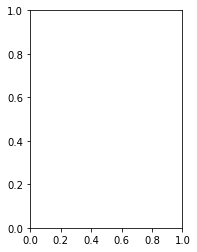

In [8]:
NX = 48
NY = 56
BACKGROUND_LABEL = np.zeros((NX,NY))

def read_label(idx):
    sample = data.loc[idx]
    if sample.folder == 'background/':
        return BACKGROUND_LABEL
    else:
        fname = SPECIM + 'NPY_data/' + sample.folder + str(sample.frame) + '.npy'
        return np.load(fname)

def read_image(idx):
    sample = data.loc[idx]
    if sample.folder == 'background/':
        idx = np.random.choice(len(BACKGROUND))
        return BACKGROUND[idx]
    elif sample.folder == 'realfakelabel/':
        return REALFAKE[sample.frame]
    elif sample.folder == 'reallabel/':
        return REAL[sample.frame]
    elif sample.folder == 'fakelabel/':
        return FAKE[sample.frame]
    else:
        raise ValueError('frame not found')
    
for i in range(len(data)):
    plt.subplot(121)
    plt.imshow(read_image(i)[:,:,0])
    plt.subplot(122)
    plt.imshow(read_label(i))
    plt.show()

In [21]:
import h5py
import os
import glob
import torch
import numpy as np
import pandas as pd
from skimage import io, transform
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split


normalize = transforms.Normalize((0.5)*34, (0.5)*34)
VALIDATION_SPLIT = 0.01
CHANNELS = 9

class Resize(object):
    def __init__(self, target_size=(256,256)):
        self.target_size = target_size
    def __call__(self, sample):
        target_size = self.target_size
        x = sample['image']
        y = sample['label']
        sample['image'] = transform.resize(x, (target_size[0], target_size[1]))
        sample['label'] = transform.resize(y, (target_size[0], target_size[1]),
                                           anti_aliasing=False,
                                           preserve_range=True,
                                          order=0).astype(int)
        return sample

class RandomHorizontalFlip():
    def __init__(self, prob=0.5):
        self.prob = prob
    
    def __call__(self, sample):
        x = sample['image']
        y = sample['label']
        if np.random.rand(1) < self.prob:
            sample['image'] = torch.flip(x,dims=(-1,))
            sample['label'] = torch.flip(y,dims=(-1,))
        return sample
    
class ImageNormalize(object):
    def __call__(self, sample):
        x = sample['image']
        sample['image'] = normalize(x)
        return sample
    
class Clamp():
    def __call__(self, sample):
        x = sample['image']
        sample['image'] = torch.clamp(sample['image'],0.0,1.0)
        return sample
    
class RandomHorizontalFlip():
    def __init__(self, prob=0.5):
        self.prob = prob
    
    def __call__(self, sample):
        x = sample['image']
        y = sample['label']
        if np.random.rand(1) < self.prob:
            sample['image'] = torch.flip(x,dims=(-1,))
            sample['label'] = torch.flip(y,dims=(-1,))
        return sample

    
class SegIdentityTransform(object):
    # Hint: Note that our transforms work on dicts. This is an example of a transform that works
    # on a dict whose elements can be converted to np.arrays, and are then converted to torch.tensors
    # This performs the scaling of the RGB by division by 255, and puts channels first by performing the permute
    # for the label, we convert to long, datatype to let torch know that this is a discrete label.
    # You might want to change this or write different transforms depending on how you read data.
    def __call__(self, sample):
        return {'image': torch.tensor(np.array(sample['image'])).permute(2,0,1),
                'label': torch.tensor(np.array(sample['label'])).long()}
    
class RandomCrop():
    def __init__(self, target_size=(256,256), edge=10):
        self.target_size = target_size
        self.edge = edge
    def __call__(self, sample):
        if min(sample['label'].shape) < max(self.target_size) + 2*self.edge:
            sample = Resize(self.target_size)(sample)
            return sample
        wx, wy = self.target_size
        wx0 , wy0 = sample['label'].shape
        try:
            center_x = np.random.randint(self.edge+wx//2,wx0 - self.edge - wx//2)
            center_y = np.random.randint(self.edge+wy//2,wy0 - self.edge - wy//2)
        except:
            print(sample['label'].shape)
        crop_x_0 = center_x - wx // 2
        crop_x_1 = center_x + wx // 2
        crop_y_0 = center_y - wy // 2
        crop_y_1 = center_y + wy // 2
        sample['image'] = sample['image'][crop_x_0:crop_x_1,crop_y_0:crop_y_1].astype(float)
        sample['label'] = sample['label'][crop_x_0:crop_x_1,crop_y_0:crop_y_1].astype(int)
        return sample
    
class RandomCropHoriz():
    def __init__(self, target_size=(256,256), edge=10, shift=170):
        self.target_size = target_size
        self.edge = edge
        self.shift = shift
    def __call__(self, sample):
        if min(sample['label'].shape) < max(self.target_size) + 2*self.edge:
            sample = Resize(self.target_size)(sample)
            return sample
        wx, wy = self.target_size
        wx0 , wy0 = sample['label'].shape
        try:
            center_x = np.random.randint(self.edge+wx//2,wx0 - self.edge - wx//2)
            center_y = np.random.randint(self.edge+wy//2,wy0 - self.edge - wy//2)
        except:
            print(sample['label'].shape)
        crop_x_0 = center_x - wx // 2
        crop_x_1 = center_x + wx // 2
        crop_y_0 = center_y - wy // 2
        crop_y_1 = center_y + wy // 2
        sample['image'] = sample['image'][self.shift:self.shift+self.target_size[0],crop_y_0:crop_y_1].astype(float)
        sample['label'] = sample['label'][self.shift:self.shift+self.target_size[0],crop_y_0:crop_y_1].astype(int)
        return sample
    
class_names = ['bg,',
                    'real apple',
                    'real pepper',
                    'real grape',
                    'fake apple',
                    'fake pepper',
                    'fake grape']

def get_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0],
                       [128, 0, 0],
                       [0, 128, 0],
                       [128, 128, 0],
                       [0, 0, 128],
                       [128, 0, 128],
                       [0, 128, 128]])

def encode_segmap(mask):
    """Encode segmentation label images as pascal classes
    Args:
        mask (np.ndarray): raw segmentation label image of dimension
          (M, N, 3), in which the Pascal classes are encoded as colours.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """

    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)
    for i, label in enumerate(get_labels()):
        label_mask[np.where(np.all(mask==label, axis=-1))[:2]] = i
    return label_mask

def decode_segmap(mask, unk_label=255):
    """Decode segmentation label prediction as RGB images
    Args:
        mask (torch.tensor): class map with dimensions (B, M,N), where the value at
        a given location is the integer denoting the class index.
    Returns:
        (np.ndarray): colored image of shape (BM, BN, 3)
    """
    mask[mask == unk_label] == 0
    mask = mask.numpy()
    cmap = get_labels()
    cmap_exp = cmap[..., None]
    colored = cmap[mask].squeeze()
    grid = make_grid(torch.tensor(colored).permute(0, 3, 1, 2))
    return np.transpose(grid, (1, 2, 0))
    
class HySpecSegmentation(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform 
        self.image_files = os.listdir(root_dir)
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.image_files)
    
    def read_image(self, idx):
        filename = self.root_dir + self.image_files[idx]
        with h5py.File(filename, "r") as f:
            # List all groups
            a_group_key = list(f.keys())[0]
            # Get the data
            data = list(f[a_group_key])
        return np.stack(data,axis=-1)

    def __getitem__(self, idx):
        image = self.read_image(idx)       
        sample = {'image': image, 'label': image}    
        return self.transform(sample) if self.transform else sample
    
class CameraSegmentation(Dataset):
    def __init__(self, root_dir, datafile='data.csv', transform=None):
        self.data = pd.read_csv(datafile, index_col=0)
        self.transform = transform 
        self.root_dir = root_dir
        self.class_names = ['bg,',
                    'real apple',
                    'real pepper',
                    'real grape',
                    'fake apple',
                    'fake pepper',
                    'fake grape']
        self.num_classes = len(self.class_names)
    
        
    def __len__(self):
        return len(self.data)
    
    def read_label(self, idx):
        sample = self.data.loc[idx]
        if sample.folder == 'background/':
            return BACKGROUND_LABEL
        else:
            fname = SPECIM + 'NPY_data/' + sample.folder + str(sample.frame) + '.npy'
            return np.load(fname)

    def read_image(self, idx):
        sample = self.data.loc[idx]
        if sample.folder == 'background/':
            idx = np.random.choice(len(BACKGROUND))
            return BACKGROUND[idx]
        elif sample.folder == 'realfakelabel/':
            return REALFAKE[sample.frame]
        elif sample.folder == 'reallabel/':
            return REAL[sample.frame]
        elif sample.folder == 'fakelabel/':
            return FAKE[sample.frame]
        else:
            raise ValueError('frame not found')

    def __getitem__(self, idx):
        image = self.read_image(idx)[:,:,:CHANNELS]
        label = self.read_label(idx)  
        sample = {'image': image, 'label': label}    
        return self.transform(sample) if self.transform else sample
    
def prep_loaders(root_dir=None, hyspec=True, batch_size=1, workers=1):
    # Load dataset
    if hyspec:
        image_depth_dataset = HySpecSegmentation(root_dir=root_dir, transform=transforms.Compose([RandomCropHoriz(),SegIdentityTransform(),RandomHorizontalFlip()]))
    else:
        image_depth_dataset = CameraSegmentation(root_dir=root_dir, transform=transforms.Compose([Resize(), SegIdentityTransform(), RandomHorizontalFlip()]))

    # Split into training and validation sets
    train_size = int((1-VALIDATION_SPLIT) * len(image_depth_dataset))
    test_size = len(image_depth_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(image_depth_dataset, [train_size, test_size])

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
    print('Dataset size (num. batches)', len(train_loader), len(valid_loader))
    return train_loader, valid_loader

In [23]:
batch_size=8
workers = 1
train_loader, valid_loader = prep_loaders(SPECIM, hyspec=False, batch_size=batch_size, workers=workers)

Dataset size (num. batches) 16 1


In [24]:
sample = iter(train_loader).next()
# plt.subplots(121)
# plt.imshow(sample['label'][3])
# plt.subplots(122)
# plt.imshow(sample['image'][3,0])
# plt.show()

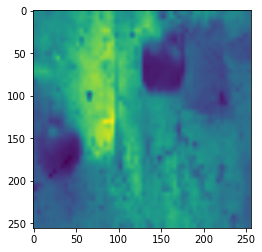

In [25]:
plt.imshow(sample['image'][6,2])

Populating the interactive namespace from numpy and matplotlib


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['bg,' 'real apple' 'real pepper' 'real grape' 'fake apple' 'fake pepper'
 'fake grape']


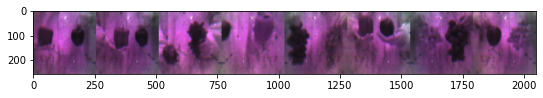

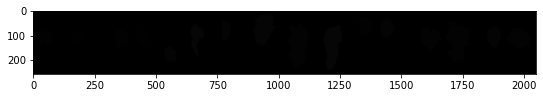

In [26]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
print(np.array(class_names)[sample['label'].unique()])
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['image'][:,:3,:,:], padding=0).permute((1, 2, 0)))
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['label'][:,None,...], padding=0).permute((1, 2, 0)))

In [27]:
n_classes = len(class_names)
n_classes

7

In [16]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=CHANNELS, out_channels=n_classes, pretrained=False).to(device)

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [28]:
from utils import Metrics
loss_fn = nn.CrossEntropyLoss()

In [31]:
import os
import gc
import time
import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

train_pretrained=False
epochs = 300
batch_size = 8
learning_rate = 1e-4
workers = 1 # The number of parallel processes used to read data
gpu_id = [0] # only modify if you machine has more than one GPU card

In [32]:
run_id = 'segmentation_rgb_gpu{}_n{}_bs{}_lr{}_pretrained{}_loss_{}_time_{}'.format(gpu_id, epochs, batch_size, learning_rate, train_pretrained,'cross_entropy', str(datetime.datetime.now().time())); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(params= model.parameters(),lr=learning_rate)

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
metrics = Metrics(train_loader.dataset.dataset.num_classes, train_loader.dataset.dataset.class_names)

# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH


for epoch in range(epochs):
    model.train()

    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()
    
    
    iteration_losses = []

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['label'].long().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT) == 0:
            print('.', end='')

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y; gc.collect()

    # Validation after each epoch
    #model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['label'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    print('\nValidation stats ', metrics.get_table())
    # Save model
    iteration_losses.append(losses.avg)
    torch.save(model.state_dict(), save_path)
    np.save(run_id, iteration_losses)

ans = np.load(run_id+'.npy')
plt.plot(ans[:,0])
plt.plot(np.array(ans[:,1])-0.001)
plt.show()

print('\nTraining done. Model saved ({}).'.format(save_path))



Training segmentation_rgb_gpu[0]_n300_bs8_lr0.0001_pretrainedFalse_loss_cross_entropy_time_22:12:11.271030

Epoch: [0][0/16]	Time 0.438 (0.438)	ETA 0:00:07	Training Loss 1.7591 (1.7591)

Epoch: [0][1/16]	Time 0.179 (0.616)	ETA 0:00:02	Training Loss 1.7570 (1.7581)

Epoch: [0][2/16]	Time 0.176 (0.792)	ETA 0:00:02	Training Loss 1.7461 (1.7541)

Epoch: [0][3/16]	Time 0.193 (0.985)	ETA 0:00:02	Training Loss 1.7527 (1.7537)

Epoch: [0][4/16]	Time 0.190 (1.175)	ETA 0:00:02	Training Loss 1.7494 (1.7528)

Epoch: [0][5/16]	Time 0.182 (1.357)	ETA 0:00:02	Training Loss 1.7502 (1.7524)

Epoch: [0][6/16]	Time 0.188 (1.545)	ETA 0:00:01	Training Loss 1.7389 (1.7505)

Epoch: [0][7/16]	Time 0.186 (1.731)	ETA 0:00:01	Training Loss 1.7557 (1.7511)

Epoch: [0][8/16]	Time 0.186 (1.917)	ETA 0:00:01	Training Loss 1.7522 (1.7513)

Epoch: [0][9/16]	Time 0.184 (2.101)	ETA 0:00:01	Training Loss 1.7413 (1.7503)

Epoch: [0][10/16]	Time 0.205 (2.306)	ETA 0:00:01	Training Loss 1.7443 (1.7497)

Epoch: [0][11/16]	Ti


Epoch: [4][6/16]	Time 0.210 (1.549)	ETA 0:00:02	Training Loss 1.7046 (1.7074)

Epoch: [4][7/16]	Time 0.192 (1.741)	ETA 0:00:01	Training Loss 1.6944 (1.7058)

Epoch: [4][8/16]	Time 0.186 (1.927)	ETA 0:00:01	Training Loss 1.7006 (1.7052)

Epoch: [4][9/16]	Time 0.185 (2.112)	ETA 0:00:01	Training Loss 1.6963 (1.7043)

Epoch: [4][10/16]	Time 0.190 (2.302)	ETA 0:00:01	Training Loss 1.6981 (1.7037)

Epoch: [4][11/16]	Time 0.190 (2.492)	ETA 0:00:00	Training Loss 1.7042 (1.7038)

Epoch: [4][12/16]	Time 0.185 (2.677)	ETA 0:00:00	Training Loss 1.7053 (1.7039)

Epoch: [4][13/16]	Time 0.193 (2.870)	ETA 0:00:00	Training Loss 1.6969 (1.7034)

Epoch: [4][14/16]	Time 0.195 (3.066)	ETA 0:00:00	Training Loss 1.7043 (1.7034)

Epoch: [4][15/16]	Time 0.112 (3.177)	ETA 0:00:00	Training Loss 1.6984 (1.7033)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.939300  0.968700  0.978300  0.959300  0.946100
real apple   0.008800  0.017400  0.166000  0.009200  0.93190


Epoch: [8][14/16]	Time 0.184 (3.047)	ETA 0:00:00	Training Loss 1.6751 (1.6715)

Epoch: [8][15/16]	Time 0.114 (3.161)	ETA 0:00:00	Training Loss 1.6606 (1.6711)
_
Validation stats                    IoU      F1      Prec    recall       Acc
bg,          0.935000  0.9664  0.980800  0.952500  0.942500
real apple   0.002800  0.0055  0.193500  0.002800  0.933700
real pepper  0.000000  0.0000  0.000000  0.000000  1.000000
real grape   0.011200  0.0221  0.072700  0.013100  0.925300
fake apple   0.000000  0.0000  0.000000  0.000000  0.942000
fake pepper  0.000000  0.0000  0.000000  0.000000  0.996200
fake grape   0.000000  0.0000  0.000000  0.000000  0.918800
total        0.135571  0.1420  0.178143  0.138343  0.951214
total(-bg)   0.002333  0.0046  0.044367  0.002650  0.952667

Epoch: [9][0/16]	Time 0.474 (0.474)	ETA 0:00:07	Training Loss 1.6650 (1.6650)

Epoch: [9][1/16]	Time 0.183 (0.657)	ETA 0:00:02	Training Loss 1.6644 (1.6647)

Epoch: [9][2/16]	Time 0.183 (0.840)	ETA 0:00:02	Training Loss


Epoch: [13][0/16]	Time 0.415 (0.415)	ETA 0:00:06	Training Loss 1.6396 (1.6396)

Epoch: [13][1/16]	Time 0.194 (0.608)	ETA 0:00:02	Training Loss 1.6279 (1.6338)

Epoch: [13][2/16]	Time 0.189 (0.798)	ETA 0:00:02	Training Loss 1.6433 (1.6370)

Epoch: [13][3/16]	Time 0.196 (0.994)	ETA 0:00:02	Training Loss 1.6292 (1.6350)

Epoch: [13][4/16]	Time 0.191 (1.184)	ETA 0:00:02	Training Loss 1.6313 (1.6343)

Epoch: [13][5/16]	Time 0.192 (1.376)	ETA 0:00:02	Training Loss 1.6289 (1.6334)

Epoch: [13][6/16]	Time 0.189 (1.565)	ETA 0:00:01	Training Loss 1.6433 (1.6348)

Epoch: [13][7/16]	Time 0.188 (1.753)	ETA 0:00:01	Training Loss 1.6360 (1.6350)

Epoch: [13][8/16]	Time 0.192 (1.945)	ETA 0:00:01	Training Loss 1.6260 (1.6340)

Epoch: [13][9/16]	Time 0.199 (2.143)	ETA 0:00:01	Training Loss 1.6223 (1.6328)

Epoch: [13][10/16]	Time 0.197 (2.340)	ETA 0:00:01	Training Loss 1.6302 (1.6326)

Epoch: [13][11/16]	Time 0.195 (2.536)	ETA 0:00:00	Training Loss 1.6313 (1.6325)

Epoch: [13][12/16]	Time 0.196 (2.731)


Epoch: [17][8/16]	Time 0.189 (1.920)	ETA 0:00:01	Training Loss 1.6056 (1.6071)

Epoch: [17][9/16]	Time 0.194 (2.114)	ETA 0:00:01	Training Loss 1.6180 (1.6082)

Epoch: [17][10/16]	Time 0.194 (2.308)	ETA 0:00:01	Training Loss 1.6091 (1.6083)

Epoch: [17][11/16]	Time 0.185 (2.493)	ETA 0:00:00	Training Loss 1.5900 (1.6067)

Epoch: [17][12/16]	Time 0.194 (2.687)	ETA 0:00:00	Training Loss 1.6026 (1.6064)

Epoch: [17][13/16]	Time 0.186 (2.873)	ETA 0:00:00	Training Loss 1.6028 (1.6062)

Epoch: [17][14/16]	Time 0.186 (3.059)	ETA 0:00:00	Training Loss 1.5993 (1.6057)

Epoch: [17][15/16]	Time 0.111 (3.170)	ETA 0:00:00	Training Loss 1.5930 (1.6053)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.940800  0.969500  0.981200  0.958100  0.947600
real apple   0.000500  0.000900  0.055600  0.000500  0.933800
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.061700  0.116300  0.402100  0.068000  0.933100
fake apple   0.000000  0


Epoch: [21][15/16]	Time 0.114 (3.190)	ETA 0:00:00	Training Loss 1.5837 (1.5789)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.944000  0.971200  0.980500  0.962100  0.950400
real apple   0.000000  0.000000  0.000000  0.000000  0.933700
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.192400  0.322600  0.707100  0.209000  0.943200
fake apple   0.000000  0.000000  0.000000  0.000000  0.943300
fake pepper  0.000000  0.000000  0.000000  0.000000  0.983300
fake grape   0.000000  0.000000  0.000000  0.000000  0.946300
total        0.162343  0.184829  0.241086  0.167300  0.957171
total(-bg)   0.032067  0.053767  0.117850  0.034833  0.958300

Epoch: [22][0/16]	Time 0.473 (0.473)	ETA 0:00:07	Training Loss 1.5712 (1.5712)

Epoch: [22][1/16]	Time 0.195 (0.668)	ETA 0:00:02	Training Loss 1.5695 (1.5704)

Epoch: [22][2/16]	Time 0.184 (0.853)	ETA 0:00:02	Training Loss 1.5699 (1.5702)

Epoch: [22][3/16]	Time 0.192 (1.045)	E


Epoch: [26][0/16]	Time 0.464 (0.464)	ETA 0:00:07	Training Loss 1.5520 (1.5520)

Epoch: [26][1/16]	Time 0.176 (0.640)	ETA 0:00:02	Training Loss 1.5464 (1.5492)

Epoch: [26][2/16]	Time 0.190 (0.831)	ETA 0:00:02	Training Loss 1.5514 (1.5499)

Epoch: [26][3/16]	Time 0.189 (1.020)	ETA 0:00:02	Training Loss 1.5441 (1.5485)

Epoch: [26][4/16]	Time 0.194 (1.213)	ETA 0:00:02	Training Loss 1.5406 (1.5469)

Epoch: [26][5/16]	Time 0.178 (1.391)	ETA 0:00:01	Training Loss 1.5430 (1.5463)

Epoch: [26][6/16]	Time 0.179 (1.570)	ETA 0:00:01	Training Loss 1.5468 (1.5463)

Epoch: [26][7/16]	Time 0.197 (1.767)	ETA 0:00:01	Training Loss 1.5477 (1.5465)

Epoch: [26][8/16]	Time 0.180 (1.947)	ETA 0:00:01	Training Loss 1.5401 (1.5458)

Epoch: [26][9/16]	Time 0.174 (2.122)	ETA 0:00:01	Training Loss 1.5394 (1.5452)

Epoch: [26][10/16]	Time 0.189 (2.311)	ETA 0:00:01	Training Loss 1.5513 (1.5457)

Epoch: [26][11/16]	Time 0.183 (2.494)	ETA 0:00:00	Training Loss 1.5580 (1.5467)

Epoch: [26][12/16]	Time 0.174 (2.668)


Epoch: [30][8/16]	Time 0.182 (1.915)	ETA 0:00:01	Training Loss 1.5185 (1.5191)

Epoch: [30][9/16]	Time 0.191 (2.106)	ETA 0:00:01	Training Loss 1.5141 (1.5186)

Epoch: [30][10/16]	Time 0.196 (2.302)	ETA 0:00:01	Training Loss 1.5096 (1.5177)

Epoch: [30][11/16]	Time 0.186 (2.488)	ETA 0:00:00	Training Loss 1.5221 (1.5181)

Epoch: [30][12/16]	Time 0.192 (2.680)	ETA 0:00:00	Training Loss 1.5212 (1.5183)

Epoch: [30][13/16]	Time 0.189 (2.869)	ETA 0:00:00	Training Loss 1.5153 (1.5181)

Epoch: [30][14/16]	Time 0.190 (3.059)	ETA 0:00:00	Training Loss 1.5280 (1.5188)

Epoch: [30][15/16]	Time 0.112 (3.171)	ETA 0:00:00	Training Loss 1.5169 (1.5187)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.944700  0.971500  0.977900  0.965300  0.950800
real apple   0.000000  0.000000  0.000000  0.000000  0.934200
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.376700  0.547200  0.878200  0.397400  0.957400
fake apple   0.000000  0

_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.946900  0.972700  0.979000  0.966600  0.952900
real apple   0.000000  0.000000  0.000000  0.000000  0.934300
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.329200  0.495300  0.842600  0.350800  0.953700
fake apple   0.000000  0.000000  0.000000  0.000000  0.962700
fake pepper  0.000000  0.000000  0.000000  0.000000  0.971500
fake grape   0.000000  0.000000  0.000000  0.000000  0.951300
total        0.182300  0.209714  0.260229  0.188200  0.960914
total(-bg)   0.054867  0.082550  0.140433  0.058467  0.962250

Epoch: [35][0/16]	Time 0.466 (0.466)	ETA 0:00:07	Training Loss 1.4914 (1.4914)

Epoch: [35][1/16]	Time 0.192 (0.658)	ETA 0:00:02	Training Loss 1.4925 (1.4920)

Epoch: [35][2/16]	Time 0.185 (0.842)	ETA 0:00:02	Training Loss 1.4847 (1.4895)

Epoch: [35][3/16]	Time 0.182 (1.024)	ETA 0:00:02	Training Loss 1.4851 (1.4884)

Epoch: [35][4/16]	Time 0.186 (1.210)	ET


Epoch: [39][0/16]	Time 0.458 (0.458)	ETA 0:00:07	Training Loss 1.4701 (1.4701)

Epoch: [39][1/16]	Time 0.183 (0.640)	ETA 0:00:02	Training Loss 1.4779 (1.4740)

Epoch: [39][2/16]	Time 0.192 (0.832)	ETA 0:00:02	Training Loss 1.4659 (1.4713)

Epoch: [39][3/16]	Time 0.189 (1.022)	ETA 0:00:02	Training Loss 1.4655 (1.4698)

Epoch: [39][4/16]	Time 0.187 (1.209)	ETA 0:00:02	Training Loss 1.4688 (1.4696)

Epoch: [39][5/16]	Time 0.184 (1.393)	ETA 0:00:02	Training Loss 1.4641 (1.4687)

Epoch: [39][6/16]	Time 0.188 (1.581)	ETA 0:00:01	Training Loss 1.4639 (1.4680)

Epoch: [39][7/16]	Time 0.180 (1.761)	ETA 0:00:01	Training Loss 1.4632 (1.4674)

Epoch: [39][8/16]	Time 0.183 (1.944)	ETA 0:00:01	Training Loss 1.4595 (1.4665)

Epoch: [39][9/16]	Time 0.188 (2.132)	ETA 0:00:01	Training Loss 1.4646 (1.4664)

Epoch: [39][10/16]	Time 0.193 (2.325)	ETA 0:00:01	Training Loss 1.4659 (1.4663)

Epoch: [39][11/16]	Time 0.181 (2.506)	ETA 0:00:00	Training Loss 1.4665 (1.4663)

Epoch: [39][12/16]	Time 0.185 (2.690)


Epoch: [43][8/16]	Time 0.191 (1.955)	ETA 0:00:01	Training Loss 1.4404 (1.4420)

Epoch: [43][9/16]	Time 0.183 (2.137)	ETA 0:00:01	Training Loss 1.4358 (1.4414)

Epoch: [43][10/16]	Time 0.190 (2.327)	ETA 0:00:01	Training Loss 1.4421 (1.4415)

Epoch: [43][11/16]	Time 0.205 (2.532)	ETA 0:00:01	Training Loss 1.4383 (1.4412)

Epoch: [43][12/16]	Time 0.177 (2.709)	ETA 0:00:00	Training Loss 1.4370 (1.4409)

Epoch: [43][13/16]	Time 0.185 (2.894)	ETA 0:00:00	Training Loss 1.4441 (1.4411)

Epoch: [43][14/16]	Time 0.177 (3.071)	ETA 0:00:00	Training Loss 1.4424 (1.4412)

Epoch: [43][15/16]	Time 0.114 (3.185)	ETA 0:00:00	Training Loss 1.4494 (1.4415)
_
Validation stats                    IoU        F1      Prec  recall     Acc
bg,          0.945400  0.971900  0.976800  0.9671  0.9514
real apple   0.000100  0.000200  0.250000  0.0001  0.9343
real pepper  0.000000  0.000000  0.000000  0.0000  1.0000
real grape   0.142900  0.250000  0.672700  0.1535  0.9404
fake apple   0.000000  0.000000  0.000000  0

_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.943200  0.970700  0.980100  0.961700  0.949700
real apple   0.018700  0.036700  0.760600  0.018800  0.935100
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.588300  0.740700  0.886100  0.636400  0.971200
fake apple   0.000000  0.000000  0.000000  0.000000  0.939300
fake pepper  0.000000  0.000000  0.000000  0.000000  0.995600
fake grape   0.000000  0.000000  0.000000  0.000000  0.966400
total        0.221457  0.249729  0.375257  0.230986  0.965329
total(-bg)   0.101167  0.129567  0.274450  0.109200  0.967933

Epoch: [48][0/16]	Time 0.348 (0.348)	ETA 0:00:05	Training Loss 1.4141 (1.4141)

Epoch: [48][1/16]	Time 0.183 (0.530)	ETA 0:00:02	Training Loss 1.4210 (1.4175)

Epoch: [48][2/16]	Time 0.188 (0.719)	ETA 0:00:02	Training Loss 1.4178 (1.4176)

Epoch: [48][3/16]	Time 0.196 (0.915)	ETA 0:00:02	Training Loss 1.4142 (1.4168)

Epoch: [48][4/16]	Time 0.181 (1.096)	ET


Epoch: [52][0/16]	Time 0.480 (0.480)	ETA 0:00:07	Training Loss 1.3981 (1.3981)

Epoch: [52][1/16]	Time 0.186 (0.666)	ETA 0:00:02	Training Loss 1.3969 (1.3975)

Epoch: [52][2/16]	Time 0.189 (0.855)	ETA 0:00:02	Training Loss 1.3980 (1.3977)

Epoch: [52][3/16]	Time 0.185 (1.041)	ETA 0:00:02	Training Loss 1.3972 (1.3976)

Epoch: [52][4/16]	Time 0.184 (1.225)	ETA 0:00:02	Training Loss 1.3994 (1.3979)

Epoch: [52][5/16]	Time 0.192 (1.417)	ETA 0:00:02	Training Loss 1.3970 (1.3978)

Epoch: [52][6/16]	Time 0.188 (1.605)	ETA 0:00:01	Training Loss 1.3979 (1.3978)

Epoch: [52][7/16]	Time 0.188 (1.793)	ETA 0:00:01	Training Loss 1.3923 (1.3971)

Epoch: [52][8/16]	Time 0.192 (1.985)	ETA 0:00:01	Training Loss 1.3958 (1.3970)

Epoch: [52][9/16]	Time 0.185 (2.170)	ETA 0:00:01	Training Loss 1.3907 (1.3963)

Epoch: [52][10/16]	Time 0.186 (2.356)	ETA 0:00:01	Training Loss 1.3943 (1.3961)

Epoch: [52][11/16]	Time 0.194 (2.551)	ETA 0:00:00	Training Loss 1.3886 (1.3955)

Epoch: [52][12/16]	Time 0.195 (2.746)


Epoch: [56][8/16]	Time 0.185 (1.997)	ETA 0:00:01	Training Loss 1.3787 (1.3832)

Epoch: [56][9/16]	Time 0.186 (2.183)	ETA 0:00:01	Training Loss 1.3879 (1.3837)

Epoch: [56][10/16]	Time 0.205 (2.389)	ETA 0:00:01	Training Loss 1.3815 (1.3835)

Epoch: [56][11/16]	Time 0.190 (2.579)	ETA 0:00:00	Training Loss 1.3770 (1.3829)

Epoch: [56][12/16]	Time 0.181 (2.759)	ETA 0:00:00	Training Loss 1.3755 (1.3823)

Epoch: [56][13/16]	Time 0.197 (2.956)	ETA 0:00:00	Training Loss 1.3789 (1.3821)

Epoch: [56][14/16]	Time 0.193 (3.149)	ETA 0:00:00	Training Loss 1.3766 (1.3817)

Epoch: [56][15/16]	Time 0.116 (3.265)	ETA 0:00:00	Training Loss 1.3768 (1.3816)
_
Validation stats                    IoU        F1      Prec   recall       Acc
bg,          0.929400  0.963400  0.977500  0.94980  0.937300
real apple   0.015300  0.030200  1.000000  0.01530  0.935300
real pepper  0.000000  0.000000  0.000000  0.00000  1.000000
real grape   0.472300  0.641500  0.899300  0.49860  0.963900
fake apple   0.000000  0.0000

_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.951300  0.975000  0.978000  0.972100  0.956700
real apple   0.090900  0.166600  0.858500  0.092300  0.939300
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.558300  0.716500  0.914100  0.589300  0.969800
fake apple   0.000000  0.000000  0.000000  0.000000  0.948500
fake pepper  0.000000  0.000000  0.000000  0.000000  0.995400
fake grape   0.000000  0.000000  0.000000  0.000000  0.969200
total        0.228643  0.265443  0.392943  0.236243  0.968414
total(-bg)   0.108200  0.147183  0.295433  0.113600  0.970367

Epoch: [61][0/16]	Time 0.435 (0.435)	ETA 0:00:06	Training Loss 1.3585 (1.3585)

Epoch: [61][1/16]	Time 0.187 (0.622)	ETA 0:00:02	Training Loss 1.3556 (1.3570)

Epoch: [61][2/16]	Time 0.184 (0.806)	ETA 0:00:02	Training Loss 1.3590 (1.3577)

Epoch: [61][3/16]	Time 0.185 (0.991)	ETA 0:00:02	Training Loss 1.3696 (1.3607)

Epoch: [61][4/16]	Time 0.188 (1.178)	ET


Epoch: [65][0/16]	Time 0.369 (0.369)	ETA 0:00:05	Training Loss 1.3447 (1.3447)

Epoch: [65][1/16]	Time 0.184 (0.554)	ETA 0:00:02	Training Loss 1.3440 (1.3443)

Epoch: [65][2/16]	Time 0.188 (0.741)	ETA 0:00:02	Training Loss 1.3446 (1.3444)

Epoch: [65][3/16]	Time 0.183 (0.925)	ETA 0:00:02	Training Loss 1.3607 (1.3485)

Epoch: [65][4/16]	Time 0.188 (1.112)	ETA 0:00:02	Training Loss 1.3435 (1.3475)

Epoch: [65][5/16]	Time 0.182 (1.295)	ETA 0:00:02	Training Loss 1.3579 (1.3492)

Epoch: [65][6/16]	Time 0.188 (1.483)	ETA 0:00:01	Training Loss 1.3498 (1.3493)

Epoch: [65][7/16]	Time 0.186 (1.669)	ETA 0:00:01	Training Loss 1.3454 (1.3488)

Epoch: [65][8/16]	Time 0.207 (1.876)	ETA 0:00:01	Training Loss 1.3429 (1.3482)

Epoch: [65][9/16]	Time 0.189 (2.065)	ETA 0:00:01	Training Loss 1.3417 (1.3475)

Epoch: [65][10/16]	Time 0.185 (2.250)	ETA 0:00:01	Training Loss 1.3492 (1.3477)

Epoch: [65][11/16]	Time 0.183 (2.433)	ETA 0:00:00	Training Loss 1.3428 (1.3473)

Epoch: [65][12/16]	Time 0.186 (2.619)


Epoch: [69][8/16]	Time 0.182 (1.961)	ETA 0:00:01	Training Loss 1.3319 (1.3330)

Epoch: [69][9/16]	Time 0.187 (2.148)	ETA 0:00:01	Training Loss 1.3399 (1.3337)

Epoch: [69][10/16]	Time 0.199 (2.346)	ETA 0:00:01	Training Loss 1.3276 (1.3331)

Epoch: [69][11/16]	Time 0.186 (2.533)	ETA 0:00:00	Training Loss 1.3331 (1.3331)

Epoch: [69][12/16]	Time 0.186 (2.718)	ETA 0:00:00	Training Loss 1.3403 (1.3337)

Epoch: [69][13/16]	Time 0.186 (2.904)	ETA 0:00:00	Training Loss 1.3340 (1.3337)

Epoch: [69][14/16]	Time 0.182 (3.086)	ETA 0:00:00	Training Loss 1.3356 (1.3338)

Epoch: [69][15/16]	Time 0.116 (3.202)	ETA 0:00:00	Training Loss 1.3353 (1.3339)
_
Validation stats                    IoU        F1     Prec    recall       Acc
bg,          0.944000  0.971200  0.97730  0.965100  0.950200
real apple   0.097400  0.177500  0.95360  0.097900  0.940400
real pepper  0.000000  0.000000  0.00000  0.000000  1.000000
real grape   0.662600  0.797000  0.89710  0.717100  0.976400
fake apple   0.000000  0.0000

_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.953000  0.975900  0.976700  0.975200  0.958200
real apple   0.039800  0.076500  0.910100  0.039900  0.936600
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.679300  0.809000  0.944500  0.707600  0.978400
fake apple   0.000000  0.000000  0.000000  0.000000  0.957700
fake pepper  0.000000  0.000000  0.000000  0.000000  0.983800
fake grape   0.000000  0.000000  0.000000  0.000000  0.978100
total        0.238871  0.265914  0.404471  0.246100  0.970400
total(-bg)   0.119850  0.147583  0.309100  0.124583  0.972433

Epoch: [74][0/16]	Time 0.474 (0.474)	ETA 0:00:07	Training Loss 1.3175 (1.3175)

Epoch: [74][1/16]	Time 0.184 (0.658)	ETA 0:00:02	Training Loss 1.3201 (1.3188)

Epoch: [74][2/16]	Time 0.190 (0.848)	ETA 0:00:02	Training Loss 1.3225 (1.3200)

Epoch: [74][3/16]	Time 0.185 (1.032)	ETA 0:00:02	Training Loss 1.3249 (1.3212)

Epoch: [74][4/16]	Time 0.189 (1.222)	ET


Epoch: [78][0/16]	Time 0.360 (0.360)	ETA 0:00:05	Training Loss 1.3063 (1.3063)

Epoch: [78][1/16]	Time 0.183 (0.543)	ETA 0:00:02	Training Loss 1.3063 (1.3063)

Epoch: [78][2/16]	Time 0.187 (0.730)	ETA 0:00:02	Training Loss 1.3182 (1.3102)

Epoch: [78][3/16]	Time 0.186 (0.916)	ETA 0:00:02	Training Loss 1.3142 (1.3112)

Epoch: [78][4/16]	Time 0.184 (1.100)	ETA 0:00:02	Training Loss 1.3076 (1.3105)

Epoch: [78][5/16]	Time 0.195 (1.295)	ETA 0:00:02	Training Loss 1.3092 (1.3103)

Epoch: [78][6/16]	Time 0.180 (1.475)	ETA 0:00:01	Training Loss 1.3106 (1.3103)

Epoch: [78][7/16]	Time 0.194 (1.668)	ETA 0:00:01	Training Loss 1.3068 (1.3099)

Epoch: [78][8/16]	Time 0.184 (1.852)	ETA 0:00:01	Training Loss 1.3073 (1.3096)

Epoch: [78][9/16]	Time 0.186 (2.038)	ETA 0:00:01	Training Loss 1.3085 (1.3095)

Epoch: [78][10/16]	Time 0.192 (2.230)	ETA 0:00:01	Training Loss 1.3084 (1.3094)

Epoch: [78][11/16]	Time 0.194 (2.424)	ETA 0:00:00	Training Loss 1.3077 (1.3092)

Epoch: [78][12/16]	Time 0.186 (2.610)


Epoch: [82][8/16]	Time 0.191 (1.917)	ETA 0:00:01	Training Loss 1.3010 (1.3000)

Epoch: [82][9/16]	Time 0.194 (2.111)	ETA 0:00:01	Training Loss 1.2963 (1.2996)

Epoch: [82][10/16]	Time 0.188 (2.299)	ETA 0:00:01	Training Loss 1.2985 (1.2995)

Epoch: [82][11/16]	Time 0.181 (2.480)	ETA 0:00:00	Training Loss 1.3030 (1.2998)

Epoch: [82][12/16]	Time 0.189 (2.668)	ETA 0:00:00	Training Loss 1.2992 (1.2998)

Epoch: [82][13/16]	Time 0.191 (2.860)	ETA 0:00:00	Training Loss 1.2966 (1.2995)

Epoch: [82][14/16]	Time 0.187 (3.047)	ETA 0:00:00	Training Loss 1.2975 (1.2994)

Epoch: [82][15/16]	Time 0.114 (3.161)	ETA 0:00:00	Training Loss 1.3111 (1.2998)
_
Validation stats                    IoU        F1      Prec    recall      Acc
bg,          0.948900  0.973700  0.976300  0.971300  0.95460
real apple   0.032900  0.063800  0.979300  0.033000  0.93640
real pepper  0.000000  0.000000  0.000000  0.000000  1.00000
real grape   0.715300  0.834000  0.907600  0.771500  0.98010
fake apple   0.000000  0.0000

_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.952800  0.975800  0.975100  0.976600  0.958000
real apple   0.239500  0.386400  0.837700  0.251100  0.947600
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.809800  0.894900  0.922900  0.868600  0.986800
fake apple   0.000000  0.000000  0.000000  0.000000  0.966000
fake pepper  0.000000  0.000000  0.000000  0.000000  0.993600
fake grape   0.000000  0.000000  0.000000  0.000000  0.991800
total        0.286014  0.322443  0.390814  0.299471  0.977686
total(-bg)   0.174883  0.213550  0.293433  0.186617  0.980967

Epoch: [87][0/16]	Time 0.405 (0.405)	ETA 0:00:06	Training Loss 1.2890 (1.2890)

Epoch: [87][1/16]	Time 0.191 (0.596)	ETA 0:00:02	Training Loss 1.2891 (1.2891)

Epoch: [87][2/16]	Time 0.194 (0.790)	ETA 0:00:02	Training Loss 1.2931 (1.2904)

Epoch: [87][3/16]	Time 0.191 (0.981)	ETA 0:00:02	Training Loss 1.3033 (1.2936)

Epoch: [87][4/16]	Time 0.192 (1.173)	ET


Epoch: [91][0/16]	Time 0.490 (0.490)	ETA 0:00:07	Training Loss 1.2851 (1.2851)

Epoch: [91][1/16]	Time 0.184 (0.674)	ETA 0:00:02	Training Loss 1.2893 (1.2872)

Epoch: [91][2/16]	Time 0.180 (0.854)	ETA 0:00:02	Training Loss 1.2906 (1.2883)

Epoch: [91][3/16]	Time 0.188 (1.042)	ETA 0:00:02	Training Loss 1.2883 (1.2883)

Epoch: [91][4/16]	Time 0.184 (1.226)	ETA 0:00:02	Training Loss 1.2872 (1.2881)

Epoch: [91][5/16]	Time 0.187 (1.413)	ETA 0:00:02	Training Loss 1.2803 (1.2868)

Epoch: [91][6/16]	Time 0.183 (1.596)	ETA 0:00:01	Training Loss 1.2842 (1.2864)

Epoch: [91][7/16]	Time 0.190 (1.786)	ETA 0:00:01	Training Loss 1.2801 (1.2856)

Epoch: [91][8/16]	Time 0.183 (1.968)	ETA 0:00:01	Training Loss 1.2836 (1.2854)

Epoch: [91][9/16]	Time 0.193 (2.162)	ETA 0:00:01	Training Loss 1.2860 (1.2855)

Epoch: [91][10/16]	Time 0.191 (2.353)	ETA 0:00:01	Training Loss 1.2971 (1.2865)

Epoch: [91][11/16]	Time 0.200 (2.553)	ETA 0:00:01	Training Loss 1.2823 (1.2862)

Epoch: [91][12/16]	Time 0.188 (2.741)


Epoch: [95][8/16]	Time 0.182 (1.945)	ETA 0:00:01	Training Loss 1.2730 (1.2748)

Epoch: [95][9/16]	Time 0.184 (2.129)	ETA 0:00:01	Training Loss 1.2714 (1.2745)

Epoch: [95][10/16]	Time 0.185 (2.315)	ETA 0:00:01	Training Loss 1.2756 (1.2746)

Epoch: [95][11/16]	Time 0.185 (2.500)	ETA 0:00:00	Training Loss 1.2715 (1.2743)

Epoch: [95][12/16]	Time 0.187 (2.687)	ETA 0:00:00	Training Loss 1.2706 (1.2740)

Epoch: [95][13/16]	Time 0.180 (2.867)	ETA 0:00:00	Training Loss 1.2743 (1.2741)

Epoch: [95][14/16]	Time 0.199 (3.066)	ETA 0:00:00	Training Loss 1.2712 (1.2739)

Epoch: [95][15/16]	Time 0.123 (3.189)	ETA 0:00:00	Training Loss 1.2826 (1.2742)
_
Validation stats                    IoU        F1     Prec    recall       Acc
bg,          0.948000  0.973200  0.97450  0.972100  0.953600
real apple   0.042600  0.081600  0.97350  0.042600  0.937000
real pepper  0.000000  0.000000  0.00000  0.000000  1.000000
real grape   0.335600  0.502500  0.91500  0.346400  0.955600
fake apple   0.000000  0.0000

_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.947500  0.973000  0.976600  0.969600  0.953300
real apple   0.130600  0.231000  0.941900  0.131600  0.942400
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.788800  0.881900  0.930900  0.837900  0.985500
fake apple   0.000000  0.000000  0.000000  0.000000  0.967600
fake pepper  0.000000  0.000000  0.000000  0.000000  0.985200
fake grape   0.000000  0.000000  0.000000  0.000000  0.977900
total        0.266700  0.297986  0.407057  0.277014  0.973129
total(-bg)   0.153233  0.185483  0.312133  0.161583  0.976433

Epoch: [100][0/16]	Time 0.371 (0.371)	ETA 0:00:05	Training Loss 1.2716 (1.2716)

Epoch: [100][1/16]	Time 0.191 (0.562)	ETA 0:00:02	Training Loss 1.2683 (1.2699)

Epoch: [100][2/16]	Time 0.186 (0.748)	ETA 0:00:02	Training Loss 1.2700 (1.2700)

Epoch: [100][3/16]	Time 0.187 (0.935)	ETA 0:00:02	Training Loss 1.2655 (1.2689)

Epoch: [100][4/16]	Time 0.188 (1.12


Epoch: [104][0/16]	Time 0.416 (0.416)	ETA 0:00:06	Training Loss 1.2599 (1.2599)

Epoch: [104][1/16]	Time 0.187 (0.603)	ETA 0:00:02	Training Loss 1.2561 (1.2580)

Epoch: [104][2/16]	Time 0.187 (0.791)	ETA 0:00:02	Training Loss 1.2572 (1.2577)

Epoch: [104][3/16]	Time 0.189 (0.980)	ETA 0:00:02	Training Loss 1.2583 (1.2579)

Epoch: [104][4/16]	Time 0.199 (1.179)	ETA 0:00:02	Training Loss 1.2578 (1.2578)

Epoch: [104][5/16]	Time 0.192 (1.370)	ETA 0:00:02	Training Loss 1.2595 (1.2581)

Epoch: [104][6/16]	Time 0.193 (1.563)	ETA 0:00:01	Training Loss 1.2582 (1.2581)

Epoch: [104][7/16]	Time 0.206 (1.769)	ETA 0:00:01	Training Loss 1.2590 (1.2582)

Epoch: [104][8/16]	Time 0.176 (1.944)	ETA 0:00:01	Training Loss 1.2821 (1.2609)

Epoch: [104][9/16]	Time 0.217 (2.162)	ETA 0:00:01	Training Loss 1.2665 (1.2615)

Epoch: [104][10/16]	Time 0.185 (2.346)	ETA 0:00:01	Training Loss 1.2593 (1.2613)

Epoch: [104][11/16]	Time 0.187 (2.533)	ETA 0:00:00	Training Loss 1.2629 (1.2614)

Epoch: [104][12/16]	Time 


Epoch: [108][6/16]	Time 0.184 (1.600)	ETA 0:00:01	Training Loss 1.2535 (1.2533)

Epoch: [108][7/16]	Time 0.182 (1.782)	ETA 0:00:01	Training Loss 1.2553 (1.2535)

Epoch: [108][8/16]	Time 0.193 (1.974)	ETA 0:00:01	Training Loss 1.2537 (1.2536)

Epoch: [108][9/16]	Time 0.180 (2.155)	ETA 0:00:01	Training Loss 1.2533 (1.2535)

Epoch: [108][10/16]	Time 0.207 (2.361)	ETA 0:00:01	Training Loss 1.2524 (1.2534)

Epoch: [108][11/16]	Time 0.183 (2.545)	ETA 0:00:00	Training Loss 1.2586 (1.2539)

Epoch: [108][12/16]	Time 0.191 (2.735)	ETA 0:00:00	Training Loss 1.2513 (1.2537)

Epoch: [108][13/16]	Time 0.191 (2.926)	ETA 0:00:00	Training Loss 1.2670 (1.2546)

Epoch: [108][14/16]	Time 0.188 (3.114)	ETA 0:00:00	Training Loss 1.2534 (1.2545)

Epoch: [108][15/16]	Time 0.114 (3.228)	ETA 0:00:00	Training Loss 1.2595 (1.2547)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.950100  0.974400  0.976200  0.972700  0.955600
real apple   0.320200  0.485000  0.96940


Epoch: [112][12/16]	Time 0.186 (2.626)	ETA 0:00:00	Training Loss 1.2494 (1.2484)

Epoch: [112][13/16]	Time 0.190 (2.816)	ETA 0:00:00	Training Loss 1.2516 (1.2486)

Epoch: [112][14/16]	Time 0.187 (3.003)	ETA 0:00:00	Training Loss 1.2529 (1.2489)

Epoch: [112][15/16]	Time 0.116 (3.119)	ETA 0:00:00	Training Loss 1.2569 (1.2491)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.947100  0.972800  0.977300  0.968400  0.952900
real apple   0.409500  0.581000  0.937000  0.421100  0.960100
real pepper  0.000000  0.000000  0.000000  0.000000  0.999700
real grape   0.779300  0.875900  0.917200  0.838200  0.984600
fake apple   0.000000  0.000000  0.000000  0.000000  0.975800
fake pepper  0.000000  0.000000  0.000000  0.000000  0.988400
fake grape   0.000000  0.000000  0.000000  0.000000  0.986400
total        0.305129  0.347100  0.404500  0.318243  0.978271
total(-bg)   0.198133  0.242817  0.309033  0.209883  0.982500

Epoch: [113][0/16]	Time 0.478 (


Epoch: [117][0/16]	Time 0.481 (0.481)	ETA 0:00:07	Training Loss 1.2483 (1.2483)

Epoch: [117][1/16]	Time 0.189 (0.669)	ETA 0:00:02	Training Loss 1.2591 (1.2537)

Epoch: [117][2/16]	Time 0.187 (0.856)	ETA 0:00:02	Training Loss 1.2583 (1.2553)

Epoch: [117][3/16]	Time 0.181 (1.037)	ETA 0:00:02	Training Loss 1.2526 (1.2546)

Epoch: [117][4/16]	Time 0.188 (1.225)	ETA 0:00:02	Training Loss 1.2554 (1.2548)

Epoch: [117][5/16]	Time 0.192 (1.417)	ETA 0:00:02	Training Loss 1.2619 (1.2559)

Epoch: [117][6/16]	Time 0.196 (1.612)	ETA 0:00:01	Training Loss 1.2611 (1.2567)

Epoch: [117][7/16]	Time 0.186 (1.798)	ETA 0:00:01	Training Loss 1.2480 (1.2556)

Epoch: [117][8/16]	Time 0.186 (1.984)	ETA 0:00:01	Training Loss 1.2567 (1.2557)

Epoch: [117][9/16]	Time 0.189 (2.173)	ETA 0:00:01	Training Loss 1.2597 (1.2561)

Epoch: [117][10/16]	Time 0.187 (2.360)	ETA 0:00:01	Training Loss 1.2614 (1.2566)

Epoch: [117][11/16]	Time 0.177 (2.537)	ETA 0:00:00	Training Loss 1.2610 (1.2570)

Epoch: [117][12/16]	Time 


Epoch: [121][6/16]	Time 0.188 (1.606)	ETA 0:00:01	Training Loss 1.2473 (1.2432)

Epoch: [121][7/16]	Time 0.186 (1.792)	ETA 0:00:01	Training Loss 1.2492 (1.2439)

Epoch: [121][8/16]	Time 0.191 (1.983)	ETA 0:00:01	Training Loss 1.2463 (1.2442)

Epoch: [121][9/16]	Time 0.192 (2.175)	ETA 0:00:01	Training Loss 1.2513 (1.2449)

Epoch: [121][10/16]	Time 0.189 (2.364)	ETA 0:00:01	Training Loss 1.2418 (1.2446)

Epoch: [121][11/16]	Time 0.188 (2.552)	ETA 0:00:00	Training Loss 1.2415 (1.2444)

Epoch: [121][12/16]	Time 0.192 (2.744)	ETA 0:00:00	Training Loss 1.2446 (1.2444)

Epoch: [121][13/16]	Time 0.178 (2.922)	ETA 0:00:00	Training Loss 1.2495 (1.2447)

Epoch: [121][14/16]	Time 0.190 (3.112)	ETA 0:00:00	Training Loss 1.2386 (1.2443)

Epoch: [121][15/16]	Time 0.112 (3.224)	ETA 0:00:00	Training Loss 1.2535 (1.2446)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.951700  0.975200  0.975300  0.975200  0.956900
real apple   0.470100  0.639500  0.95140


Epoch: [125][12/16]	Time 0.309 (2.746)	ETA 0:00:01	Training Loss 1.2328 (1.2365)

Epoch: [125][13/16]	Time 0.192 (2.939)	ETA 0:00:00	Training Loss 1.2374 (1.2365)

Epoch: [125][14/16]	Time 0.188 (3.127)	ETA 0:00:00	Training Loss 1.2349 (1.2364)

Epoch: [125][15/16]	Time 0.112 (3.239)	ETA 0:00:00	Training Loss 1.2400 (1.2366)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.948600  0.973500  0.977100  0.970100  0.954200
real apple   0.482900  0.651300  0.954100  0.494400  0.965200
real pepper  0.000000  0.000000  0.000000  0.000000  0.999700
real grape   0.810100  0.895000  0.906500  0.883900  0.986600
fake apple   0.000000  0.000000  0.000000  0.000000  0.977400
fake pepper  0.000000  0.000000  0.000000  0.000000  0.993600
fake grape   0.000000  0.000000  0.000000  0.000000  0.989700
total        0.320229  0.359971  0.405386  0.335486  0.980914
total(-bg)   0.215500  0.257717  0.310100  0.229717  0.985367

Epoch: [126][0/16]	Time 0.506 (


Epoch: [130][0/16]	Time 0.470 (0.470)	ETA 0:00:07	Training Loss 1.2318 (1.2318)

Epoch: [130][1/16]	Time 0.183 (0.653)	ETA 0:00:02	Training Loss 1.2275 (1.2297)

Epoch: [130][2/16]	Time 0.186 (0.839)	ETA 0:00:02	Training Loss 1.2407 (1.2333)

Epoch: [130][3/16]	Time 0.187 (1.026)	ETA 0:00:02	Training Loss 1.2288 (1.2322)

Epoch: [130][4/16]	Time 0.191 (1.217)	ETA 0:00:02	Training Loss 1.2288 (1.2315)

Epoch: [130][5/16]	Time 0.182 (1.399)	ETA 0:00:02	Training Loss 1.2303 (1.2313)

Epoch: [130][6/16]	Time 0.195 (1.595)	ETA 0:00:01	Training Loss 1.2333 (1.2316)

Epoch: [130][7/16]	Time 0.189 (1.784)	ETA 0:00:01	Training Loss 1.2324 (1.2317)

Epoch: [130][8/16]	Time 0.183 (1.966)	ETA 0:00:01	Training Loss 1.2287 (1.2314)

Epoch: [130][9/16]	Time 0.208 (2.175)	ETA 0:00:01	Training Loss 1.2356 (1.2318)

Epoch: [130][10/16]	Time 0.188 (2.363)	ETA 0:00:01	Training Loss 1.2281 (1.2315)

Epoch: [130][11/16]	Time 0.190 (2.553)	ETA 0:00:00	Training Loss 1.2330 (1.2316)

Epoch: [130][12/16]	Time 


Epoch: [134][6/16]	Time 0.195 (1.488)	ETA 0:00:01	Training Loss 1.2244 (1.2268)

Epoch: [134][7/16]	Time 0.180 (1.668)	ETA 0:00:01	Training Loss 1.2254 (1.2266)

Epoch: [134][8/16]	Time 0.196 (1.864)	ETA 0:00:01	Training Loss 1.2229 (1.2262)

Epoch: [134][9/16]	Time 0.183 (2.047)	ETA 0:00:01	Training Loss 1.2286 (1.2264)

Epoch: [134][10/16]	Time 0.184 (2.231)	ETA 0:00:01	Training Loss 1.2252 (1.2263)

Epoch: [134][11/16]	Time 0.206 (2.437)	ETA 0:00:01	Training Loss 1.2283 (1.2265)

Epoch: [134][12/16]	Time 0.195 (2.632)	ETA 0:00:00	Training Loss 1.2246 (1.2264)

Epoch: [134][13/16]	Time 0.176 (2.808)	ETA 0:00:00	Training Loss 1.2277 (1.2265)

Epoch: [134][14/16]	Time 0.184 (2.991)	ETA 0:00:00	Training Loss 1.2239 (1.2263)

Epoch: [134][15/16]	Time 0.118 (3.109)	ETA 0:00:00	Training Loss 1.2357 (1.2266)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.949000  0.973800  0.976300  0.971400  0.954600
real apple   0.512000  0.677200  0.92970


Epoch: [138][12/16]	Time 0.189 (2.613)	ETA 0:00:00	Training Loss 1.2257 (1.2251)

Epoch: [138][13/16]	Time 0.186 (2.798)	ETA 0:00:00	Training Loss 1.2223 (1.2249)

Epoch: [138][14/16]	Time 0.189 (2.987)	ETA 0:00:00	Training Loss 1.2206 (1.2246)

Epoch: [138][15/16]	Time 0.113 (3.100)	ETA 0:00:00	Training Loss 1.2226 (1.2245)
_
Validation stats                    IoU        F1      Prec    recall     Acc
bg,          0.949700  0.974200  0.977500  0.970900  0.9553
real apple   0.550100  0.709700  0.916400  0.579200  0.9689
real pepper  0.000000  0.000000  0.000000  0.000000  1.0000
real grape   0.593700  0.745000  0.904400  0.633400  0.9719
fake apple   0.000000  0.000000  0.000000  0.000000  0.9848
fake pepper  0.000000  0.000000  0.000000  0.000000  0.9907
fake grape   0.000000  0.000000  0.000000  0.000000  0.9751
total        0.299071  0.346986  0.399757  0.311929  0.9781
total(-bg)   0.190633  0.242450  0.303467  0.202100  0.9819

Epoch: [139][0/16]	Time 0.476 (0.476)	ETA 0:00:07	T


Epoch: [143][0/16]	Time 0.473 (0.473)	ETA 0:00:07	Training Loss 1.2207 (1.2207)

Epoch: [143][1/16]	Time 0.180 (0.653)	ETA 0:00:02	Training Loss 1.2177 (1.2192)

Epoch: [143][2/16]	Time 0.194 (0.847)	ETA 0:00:02	Training Loss 1.2199 (1.2194)

Epoch: [143][3/16]	Time 0.209 (1.056)	ETA 0:00:02	Training Loss 1.2186 (1.2192)

Epoch: [143][4/16]	Time 0.166 (1.222)	ETA 0:00:01	Training Loss 1.2197 (1.2193)

Epoch: [143][5/16]	Time 0.184 (1.407)	ETA 0:00:02	Training Loss 1.2189 (1.2192)

Epoch: [143][6/16]	Time 0.181 (1.587)	ETA 0:00:01	Training Loss 1.2175 (1.2190)

Epoch: [143][7/16]	Time 0.193 (1.780)	ETA 0:00:01	Training Loss 1.2206 (1.2192)

Epoch: [143][8/16]	Time 0.190 (1.970)	ETA 0:00:01	Training Loss 1.2265 (1.2200)

Epoch: [143][9/16]	Time 0.188 (2.158)	ETA 0:00:01	Training Loss 1.2182 (1.2198)

Epoch: [143][10/16]	Time 0.188 (2.346)	ETA 0:00:01	Training Loss 1.2221 (1.2200)

Epoch: [143][11/16]	Time 0.182 (2.528)	ETA 0:00:00	Training Loss 1.2169 (1.2198)

Epoch: [143][12/16]	Time 


Epoch: [147][6/16]	Time 0.203 (1.613)	ETA 0:00:02	Training Loss 1.2192 (1.2220)

Epoch: [147][7/16]	Time 0.189 (1.802)	ETA 0:00:01	Training Loss 1.2221 (1.2220)

Epoch: [147][8/16]	Time 0.193 (1.995)	ETA 0:00:01	Training Loss 1.2222 (1.2220)

Epoch: [147][9/16]	Time 0.174 (2.169)	ETA 0:00:01	Training Loss 1.2196 (1.2218)

Epoch: [147][10/16]	Time 0.193 (2.362)	ETA 0:00:01	Training Loss 1.2250 (1.2221)

Epoch: [147][11/16]	Time 0.180 (2.542)	ETA 0:00:00	Training Loss 1.2199 (1.2219)

Epoch: [147][12/16]	Time 0.188 (2.731)	ETA 0:00:00	Training Loss 1.2198 (1.2217)

Epoch: [147][13/16]	Time 0.183 (2.913)	ETA 0:00:00	Training Loss 1.2212 (1.2217)

Epoch: [147][14/16]	Time 0.187 (3.101)	ETA 0:00:00	Training Loss 1.2225 (1.2217)

Epoch: [147][15/16]	Time 0.112 (3.213)	ETA 0:00:00	Training Loss 1.2264 (1.2219)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.957700  0.978400  0.975300  0.981500  0.962300
real apple   0.464000  0.633800  0.91690


Epoch: [151][12/16]	Time 0.200 (2.733)	ETA 0:00:00	Training Loss 1.2244 (1.2233)

Epoch: [151][13/16]	Time 0.292 (3.025)	ETA 0:00:00	Training Loss 1.2241 (1.2234)

Epoch: [151][14/16]	Time 0.222 (3.247)	ETA 0:00:00	Training Loss 1.2132 (1.2227)

Epoch: [151][15/16]	Time 0.123 (3.369)	ETA 0:00:00	Training Loss 1.2217 (1.2227)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.951400  0.975000  0.975400  0.974800  0.956700
real apple   0.453700  0.624200  0.754400  0.532400  0.957900
real pepper  0.000000  0.000000  0.000000  0.000000  0.996200
real grape   0.668500  0.801300  0.887700  0.730300  0.976600
fake apple   0.000000  0.000000  0.000000  0.000000  0.976300
fake pepper  0.000000  0.000000  0.000000  0.000000  0.999800
fake grape   0.000000  0.000000  0.000000  0.000000  0.996400
total        0.296229  0.342929  0.373929  0.319643  0.979986
total(-bg)   0.187033  0.237583  0.273683  0.210450  0.983867

Epoch: [152][0/16]	Time 0.438 (


Epoch: [156][0/16]	Time 0.424 (0.424)	ETA 0:00:06	Training Loss 1.2101 (1.2101)

Epoch: [156][1/16]	Time 0.194 (0.618)	ETA 0:00:02	Training Loss 1.2175 (1.2138)

Epoch: [156][2/16]	Time 0.182 (0.800)	ETA 0:00:02	Training Loss 1.2113 (1.2130)

Epoch: [156][3/16]	Time 0.184 (0.984)	ETA 0:00:02	Training Loss 1.2095 (1.2121)

Epoch: [156][4/16]	Time 0.184 (1.168)	ETA 0:00:02	Training Loss 1.2147 (1.2126)

Epoch: [156][5/16]	Time 0.196 (1.364)	ETA 0:00:02	Training Loss 1.2144 (1.2129)

Epoch: [156][6/16]	Time 0.188 (1.553)	ETA 0:00:01	Training Loss 1.2110 (1.2126)

Epoch: [156][7/16]	Time 0.180 (1.733)	ETA 0:00:01	Training Loss 1.2141 (1.2128)

Epoch: [156][8/16]	Time 0.186 (1.919)	ETA 0:00:01	Training Loss 1.2115 (1.2127)

Epoch: [156][9/16]	Time 0.187 (2.106)	ETA 0:00:01	Training Loss 1.2098 (1.2124)

Epoch: [156][10/16]	Time 0.182 (2.288)	ETA 0:00:01	Training Loss 1.2089 (1.2121)

Epoch: [156][11/16]	Time 0.185 (2.473)	ETA 0:00:00	Training Loss 1.2112 (1.2120)

Epoch: [156][12/16]	Time 


Epoch: [160][6/16]	Time 0.194 (1.592)	ETA 0:00:01	Training Loss 1.2104 (1.2093)

Epoch: [160][7/16]	Time 0.188 (1.780)	ETA 0:00:01	Training Loss 1.2133 (1.2098)

Epoch: [160][8/16]	Time 0.196 (1.976)	ETA 0:00:01	Training Loss 1.2071 (1.2095)

Epoch: [160][9/16]	Time 0.187 (2.164)	ETA 0:00:01	Training Loss 1.2130 (1.2099)

Epoch: [160][10/16]	Time 0.185 (2.349)	ETA 0:00:01	Training Loss 1.2054 (1.2095)

Epoch: [160][11/16]	Time 0.188 (2.537)	ETA 0:00:00	Training Loss 1.2124 (1.2097)

Epoch: [160][12/16]	Time 0.196 (2.733)	ETA 0:00:00	Training Loss 1.2070 (1.2095)

Epoch: [160][13/16]	Time 0.184 (2.917)	ETA 0:00:00	Training Loss 1.2099 (1.2095)

Epoch: [160][14/16]	Time 0.197 (3.114)	ETA 0:00:00	Training Loss 1.2054 (1.2093)

Epoch: [160][15/16]	Time 0.114 (3.228)	ETA 0:00:00	Training Loss 1.2056 (1.2091)
_
Validation stats                    IoU      F1      Prec    recall       Acc
bg,          0.954700  0.9768  0.977400  0.976200  0.959700
real apple   0.594800  0.7459  0.907100  0.6


Epoch: [164][12/16]	Time 0.200 (2.722)	ETA 0:00:00	Training Loss 1.2117 (1.2082)

Epoch: [164][13/16]	Time 0.189 (2.911)	ETA 0:00:00	Training Loss 1.2044 (1.2080)

Epoch: [164][14/16]	Time 0.183 (3.094)	ETA 0:00:00	Training Loss 1.2077 (1.2079)

Epoch: [164][15/16]	Time 0.119 (3.214)	ETA 0:00:00	Training Loss 1.2119 (1.2081)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.953100  0.975900  0.976500  0.975400  0.958300
real apple   0.349700  0.518100  0.819100  0.378900  0.953700
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.730900  0.844500  0.875000  0.816200  0.980500
fake apple   0.000000  0.000000  0.000000  0.000000  0.975400
fake pepper  0.000000  0.000000  0.000000  0.000000  0.996600
fake grape   0.000000  0.000000  0.000000  0.000000  0.987300
total        0.290529  0.334071  0.381514  0.310071  0.978829
total(-bg)   0.180100  0.227100  0.282350  0.199183  0.982250

Epoch: [165][0/16]	Time 0.487 (


Epoch: [169][0/16]	Time 0.399 (0.399)	ETA 0:00:06	Training Loss 1.2057 (1.2057)

Epoch: [169][1/16]	Time 0.189 (0.588)	ETA 0:00:02	Training Loss 1.2045 (1.2051)

Epoch: [169][2/16]	Time 0.190 (0.777)	ETA 0:00:02	Training Loss 1.2073 (1.2059)

Epoch: [169][3/16]	Time 0.186 (0.963)	ETA 0:00:02	Training Loss 1.2116 (1.2073)

Epoch: [169][4/16]	Time 0.190 (1.153)	ETA 0:00:02	Training Loss 1.2054 (1.2069)

Epoch: [169][5/16]	Time 0.192 (1.345)	ETA 0:00:02	Training Loss 1.2063 (1.2068)

Epoch: [169][6/16]	Time 0.196 (1.541)	ETA 0:00:01	Training Loss 1.2091 (1.2071)

Epoch: [169][7/16]	Time 0.198 (1.739)	ETA 0:00:01	Training Loss 1.2091 (1.2074)

Epoch: [169][8/16]	Time 0.192 (1.931)	ETA 0:00:01	Training Loss 1.2041 (1.2070)

Epoch: [169][9/16]	Time 0.195 (2.126)	ETA 0:00:01	Training Loss 1.2062 (1.2069)

Epoch: [169][10/16]	Time 0.193 (2.319)	ETA 0:00:01	Training Loss 1.2044 (1.2067)

Epoch: [169][11/16]	Time 0.190 (2.509)	ETA 0:00:00	Training Loss 1.2053 (1.2066)

Epoch: [169][12/16]	Time 


Epoch: [173][6/16]	Time 0.192 (1.545)	ETA 0:00:01	Training Loss 1.2025 (1.2040)

Epoch: [173][7/16]	Time 0.191 (1.736)	ETA 0:00:01	Training Loss 1.2057 (1.2042)

Epoch: [173][8/16]	Time 0.190 (1.926)	ETA 0:00:01	Training Loss 1.2077 (1.2046)

Epoch: [173][9/16]	Time 0.187 (2.113)	ETA 0:00:01	Training Loss 1.2023 (1.2044)

Epoch: [173][10/16]	Time 0.190 (2.304)	ETA 0:00:01	Training Loss 1.2024 (1.2042)

Epoch: [173][11/16]	Time 0.178 (2.482)	ETA 0:00:00	Training Loss 1.2037 (1.2042)

Epoch: [173][12/16]	Time 0.196 (2.678)	ETA 0:00:00	Training Loss 1.2042 (1.2042)

Epoch: [173][13/16]	Time 0.195 (2.873)	ETA 0:00:00	Training Loss 1.2087 (1.2045)

Epoch: [173][14/16]	Time 0.184 (3.056)	ETA 0:00:00	Training Loss 1.2028 (1.2044)

Epoch: [173][15/16]	Time 0.115 (3.171)	ETA 0:00:00	Training Loss 1.2053 (1.2044)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.954400  0.976600  0.977500  0.975900  0.959500
real apple   0.359900  0.529300  0.80340


Epoch: [177][13/16]	Time 0.183 (2.876)	ETA 0:00:00	Training Loss 1.2012 (1.2028)

Epoch: [177][14/16]	Time 0.184 (3.060)	ETA 0:00:00	Training Loss 1.2000 (1.2027)

Epoch: [177][15/16]	Time 0.116 (3.176)	ETA 0:00:00	Training Loss 1.2032 (1.2027)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.953100  0.976000  0.975300  0.976700  0.958200
real apple   0.320500  0.485400  0.809000  0.346800  0.951700
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.771300  0.870800  0.896900  0.846400  0.983700
fake apple   0.000000  0.000000  0.000000  0.000000  0.975200
fake pepper  0.000000  0.000000  0.000000  0.000000  0.995700
fake grape   0.000000  0.000000  0.000000  0.000000  0.989200
total        0.292129  0.333171  0.383029  0.309986  0.979100
total(-bg)   0.181967  0.226033  0.284317  0.198867  0.982583

Epoch: [178][0/16]	Time 0.419 (0.419)	ETA 0:00:06	Training Loss 1.1994 (1.1994)

Epoch: [178][1/16]	Time 0.185 (0


Epoch: [182][0/16]	Time 0.477 (0.477)	ETA 0:00:07	Training Loss 1.1959 (1.1959)

Epoch: [182][1/16]	Time 0.183 (0.660)	ETA 0:00:02	Training Loss 1.1976 (1.1967)

Epoch: [182][2/16]	Time 0.191 (0.851)	ETA 0:00:02	Training Loss 1.2004 (1.1979)

Epoch: [182][3/16]	Time 0.184 (1.035)	ETA 0:00:02	Training Loss 1.1998 (1.1984)

Epoch: [182][4/16]	Time 0.193 (1.228)	ETA 0:00:02	Training Loss 1.1994 (1.1986)

Epoch: [182][5/16]	Time 0.185 (1.413)	ETA 0:00:02	Training Loss 1.1982 (1.1985)

Epoch: [182][6/16]	Time 0.192 (1.605)	ETA 0:00:01	Training Loss 1.2010 (1.1989)

Epoch: [182][7/16]	Time 0.191 (1.796)	ETA 0:00:01	Training Loss 1.2031 (1.1994)

Epoch: [182][8/16]	Time 0.192 (1.988)	ETA 0:00:01	Training Loss 1.1974 (1.1992)

Epoch: [182][9/16]	Time 0.191 (2.179)	ETA 0:00:01	Training Loss 1.1997 (1.1992)

Epoch: [182][10/16]	Time 0.194 (2.373)	ETA 0:00:01	Training Loss 1.1996 (1.1993)

Epoch: [182][11/16]	Time 0.183 (2.556)	ETA 0:00:00	Training Loss 1.1957 (1.1990)

Epoch: [182][12/16]	Time 


Epoch: [186][6/16]	Time 0.188 (1.612)	ETA 0:00:01	Training Loss 1.1964 (1.1966)

Epoch: [186][7/16]	Time 0.185 (1.798)	ETA 0:00:01	Training Loss 1.1966 (1.1966)

Epoch: [186][8/16]	Time 0.176 (1.974)	ETA 0:00:01	Training Loss 1.1989 (1.1968)

Epoch: [186][9/16]	Time 0.186 (2.159)	ETA 0:00:01	Training Loss 1.1961 (1.1968)

Epoch: [186][10/16]	Time 0.185 (2.345)	ETA 0:00:01	Training Loss 1.1971 (1.1968)

Epoch: [186][11/16]	Time 0.184 (2.529)	ETA 0:00:00	Training Loss 1.1948 (1.1966)

Epoch: [186][12/16]	Time 0.185 (2.714)	ETA 0:00:00	Training Loss 1.1984 (1.1968)

Epoch: [186][13/16]	Time 0.179 (2.893)	ETA 0:00:00	Training Loss 1.1947 (1.1966)

Epoch: [186][14/16]	Time 0.186 (3.079)	ETA 0:00:00	Training Loss 1.1963 (1.1966)

Epoch: [186][15/16]	Time 0.112 (3.191)	ETA 0:00:00	Training Loss 1.1990 (1.1967)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.953600  0.976200  0.977500  0.975100  0.958800
real apple   0.432700  0.604000  0.86780


Epoch: [190][12/16]	Time 0.186 (2.663)	ETA 0:00:00	Training Loss 1.1940 (1.1950)

Epoch: [190][13/16]	Time 0.186 (2.849)	ETA 0:00:00	Training Loss 1.1953 (1.1950)

Epoch: [190][14/16]	Time 0.189 (3.038)	ETA 0:00:00	Training Loss 1.1941 (1.1950)

Epoch: [190][15/16]	Time 0.114 (3.152)	ETA 0:00:00	Training Loss 1.1946 (1.1949)
_
Validation stats                    IoU        F1      Prec    recall      Acc
bg,          0.955200  0.977000  0.977000  0.977100  0.96010
real apple   0.521200  0.685200  0.890300  0.557000  0.96640
real pepper  0.000000  0.000000  0.000000  0.000000  1.00000
real grape   0.741400  0.851400  0.889800  0.816300  0.98160
fake apple   0.000000  0.000000  0.000000  0.000000  0.98760
fake pepper  0.000000  0.000000  0.000000  0.000000  0.99770
fake grape   0.000000  0.000000  0.000000  0.000000  0.98480
total        0.316829  0.359086  0.393871  0.335771  0.98260
total(-bg)   0.210433  0.256100  0.296683  0.228883  0.98635

Epoch: [191][0/16]	Time 0.379 (0.379)	ETA


Epoch: [195][0/16]	Time 0.397 (0.397)	ETA 0:00:06	Training Loss 1.1924 (1.1924)

Epoch: [195][1/16]	Time 0.191 (0.588)	ETA 0:00:02	Training Loss 1.1959 (1.1941)

Epoch: [195][2/16]	Time 0.186 (0.775)	ETA 0:00:02	Training Loss 1.1920 (1.1934)

Epoch: [195][3/16]	Time 0.190 (0.965)	ETA 0:00:02	Training Loss 1.1953 (1.1939)

Epoch: [195][4/16]	Time 0.182 (1.147)	ETA 0:00:02	Training Loss 1.1954 (1.1942)

Epoch: [195][5/16]	Time 0.191 (1.338)	ETA 0:00:02	Training Loss 1.1918 (1.1938)

Epoch: [195][6/16]	Time 0.217 (1.555)	ETA 0:00:02	Training Loss 1.2039 (1.1952)

Epoch: [195][7/16]	Time 0.192 (1.747)	ETA 0:00:01	Training Loss 1.1914 (1.1947)

Epoch: [195][8/16]	Time 0.193 (1.940)	ETA 0:00:01	Training Loss 1.1959 (1.1949)

Epoch: [195][9/16]	Time 0.186 (2.126)	ETA 0:00:01	Training Loss 1.1959 (1.1950)

Epoch: [195][10/16]	Time 0.189 (2.315)	ETA 0:00:01	Training Loss 1.1915 (1.1947)

Epoch: [195][11/16]	Time 0.187 (2.503)	ETA 0:00:00	Training Loss 1.1929 (1.1945)

Epoch: [195][12/16]	Time 


Epoch: [199][6/16]	Time 0.185 (1.536)	ETA 0:00:01	Training Loss 1.1903 (1.1919)

Epoch: [199][7/16]	Time 0.189 (1.724)	ETA 0:00:01	Training Loss 1.1907 (1.1918)

Epoch: [199][8/16]	Time 0.185 (1.909)	ETA 0:00:01	Training Loss 1.1922 (1.1918)

Epoch: [199][9/16]	Time 0.179 (2.088)	ETA 0:00:01	Training Loss 1.1919 (1.1918)

Epoch: [199][10/16]	Time 0.192 (2.280)	ETA 0:00:01	Training Loss 1.1916 (1.1918)

Epoch: [199][11/16]	Time 0.184 (2.464)	ETA 0:00:00	Training Loss 1.1907 (1.1917)

Epoch: [199][12/16]	Time 0.178 (2.642)	ETA 0:00:00	Training Loss 1.1918 (1.1917)

Epoch: [199][13/16]	Time 0.188 (2.829)	ETA 0:00:00	Training Loss 1.1905 (1.1917)

Epoch: [199][14/16]	Time 0.191 (3.020)	ETA 0:00:00	Training Loss 1.1907 (1.1916)

Epoch: [199][15/16]	Time 0.116 (3.137)	ETA 0:00:00	Training Loss 1.2022 (1.1919)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.957200  0.978100  0.977200  0.979100  0.961900
real apple   0.497200  0.664200  0.88440


Epoch: [203][12/16]	Time 0.186 (2.717)	ETA 0:00:00	Training Loss 1.1923 (1.1919)

Epoch: [203][13/16]	Time 0.193 (2.910)	ETA 0:00:00	Training Loss 1.1886 (1.1917)

Epoch: [203][14/16]	Time 0.185 (3.095)	ETA 0:00:00	Training Loss 1.1910 (1.1916)

Epoch: [203][15/16]	Time 0.114 (3.209)	ETA 0:00:00	Training Loss 1.1924 (1.1916)
_
Validation stats                    IoU        F1     Prec    recall       Acc
bg,          0.958200  0.978600  0.97750  0.979900  0.962800
real apple   0.495000  0.662200  0.88090  0.530500  0.964400
real pepper  0.000000  0.000000  0.00000  0.000000  1.000000
real grape   0.748900  0.856400  0.89960  0.817200  0.982300
fake apple   0.000000  0.000000  0.00000  0.000000  0.986000
fake pepper  0.000000  0.000000  0.00000  0.000000  0.997100
fake grape   0.000000  0.000000  0.00000  0.000000  0.987000
total        0.314586  0.356743  0.39400  0.332514  0.982800
total(-bg)   0.207317  0.253100  0.29675  0.224617  0.986133

Epoch: [204][0/16]	Time 0.427 (0.427)	ETA


Epoch: [208][0/16]	Time 0.481 (0.481)	ETA 0:00:07	Training Loss 1.1882 (1.1882)

Epoch: [208][1/16]	Time 0.185 (0.666)	ETA 0:00:02	Training Loss 1.1930 (1.1906)

Epoch: [208][2/16]	Time 0.185 (0.851)	ETA 0:00:02	Training Loss 1.1876 (1.1896)

Epoch: [208][3/16]	Time 0.189 (1.040)	ETA 0:00:02	Training Loss 1.1889 (1.1894)

Epoch: [208][4/16]	Time 0.182 (1.222)	ETA 0:00:02	Training Loss 1.1914 (1.1898)

Epoch: [208][5/16]	Time 0.180 (1.402)	ETA 0:00:01	Training Loss 1.1892 (1.1897)

Epoch: [208][6/16]	Time 0.186 (1.588)	ETA 0:00:01	Training Loss 1.1902 (1.1898)

Epoch: [208][7/16]	Time 0.189 (1.777)	ETA 0:00:01	Training Loss 1.1872 (1.1895)

Epoch: [208][8/16]	Time 0.182 (1.959)	ETA 0:00:01	Training Loss 1.1911 (1.1897)

Epoch: [208][9/16]	Time 0.187 (2.146)	ETA 0:00:01	Training Loss 1.1904 (1.1897)

Epoch: [208][10/16]	Time 0.194 (2.339)	ETA 0:00:01	Training Loss 1.1898 (1.1897)

Epoch: [208][11/16]	Time 0.191 (2.530)	ETA 0:00:00	Training Loss 1.1874 (1.1895)

Epoch: [208][12/16]	Time 


Epoch: [212][6/16]	Time 0.202 (1.664)	ETA 0:00:02	Training Loss 1.1885 (1.1880)

Epoch: [212][7/16]	Time 0.192 (1.856)	ETA 0:00:01	Training Loss 1.1886 (1.1881)

Epoch: [212][8/16]	Time 0.193 (2.048)	ETA 0:00:01	Training Loss 1.1882 (1.1881)

Epoch: [212][9/16]	Time 0.198 (2.246)	ETA 0:00:01	Training Loss 1.1858 (1.1879)

Epoch: [212][10/16]	Time 0.184 (2.430)	ETA 0:00:01	Training Loss 1.1887 (1.1880)

Epoch: [212][11/16]	Time 0.202 (2.632)	ETA 0:00:01	Training Loss 1.1902 (1.1882)

Epoch: [212][12/16]	Time 0.195 (2.827)	ETA 0:00:00	Training Loss 1.1870 (1.1881)

Epoch: [212][13/16]	Time 0.179 (3.005)	ETA 0:00:00	Training Loss 1.1877 (1.1880)

Epoch: [212][14/16]	Time 0.186 (3.191)	ETA 0:00:00	Training Loss 1.1921 (1.1883)

Epoch: [212][15/16]	Time 0.115 (3.306)	ETA 0:00:00	Training Loss 1.1938 (1.1885)
_
Validation stats                    IoU       F1      Prec    recall       Acc
bg,          0.954300  0.97660  0.978100  0.975100  0.959400
real apple   0.372800  0.54310  0.810100  


Epoch: [216][12/16]	Time 0.199 (2.677)	ETA 0:00:00	Training Loss 1.1881 (1.1889)

Epoch: [216][13/16]	Time 0.181 (2.859)	ETA 0:00:00	Training Loss 1.1874 (1.1888)

Epoch: [216][14/16]	Time 0.188 (3.047)	ETA 0:00:00	Training Loss 1.1878 (1.1887)

Epoch: [216][15/16]	Time 0.114 (3.161)	ETA 0:00:00	Training Loss 1.1865 (1.1886)
_
Validation stats                    IoU        F1      Prec    recall     Acc
bg,          0.952100  0.975400  0.978900  0.972100  0.9575
real apple   0.421900  0.593300  0.794500  0.473500  0.9574
real pepper  0.000000  0.000000  0.000000  0.000000  0.9990
real grape   0.662800  0.797200  0.857500  0.744900  0.9755
fake apple   0.000000  0.000000  0.000000  0.000000  0.9816
fake pepper  0.000000  0.000000  0.000000  0.000000  0.9960
fake grape   0.000000  0.000000  0.000000  0.000000  0.9825
total        0.290971  0.337986  0.375843  0.312929  0.9785
total(-bg)   0.180783  0.231750  0.275333  0.203067  0.9820

Epoch: [217][0/16]	Time 0.493 (0.493)	ETA 0:00:07	T


Epoch: [221][0/16]	Time 0.505 (0.505)	ETA 0:00:08	Training Loss 1.1868 (1.1868)

Epoch: [221][1/16]	Time 0.180 (0.686)	ETA 0:00:02	Training Loss 1.1893 (1.1880)

Epoch: [221][2/16]	Time 0.196 (0.882)	ETA 0:00:02	Training Loss 1.1891 (1.1884)

Epoch: [221][3/16]	Time 0.180 (1.062)	ETA 0:00:02	Training Loss 1.1856 (1.1877)

Epoch: [221][4/16]	Time 0.191 (1.253)	ETA 0:00:02	Training Loss 1.1847 (1.1871)

Epoch: [221][5/16]	Time 0.180 (1.433)	ETA 0:00:01	Training Loss 1.1875 (1.1871)

Epoch: [221][6/16]	Time 0.190 (1.623)	ETA 0:00:01	Training Loss 1.1891 (1.1874)

Epoch: [221][7/16]	Time 0.186 (1.810)	ETA 0:00:01	Training Loss 1.1861 (1.1873)

Epoch: [221][8/16]	Time 0.188 (1.997)	ETA 0:00:01	Training Loss 1.1847 (1.1870)

Epoch: [221][9/16]	Time 0.186 (2.183)	ETA 0:00:01	Training Loss 1.1857 (1.1869)

Epoch: [221][10/16]	Time 0.192 (2.375)	ETA 0:00:01	Training Loss 1.1858 (1.1868)

Epoch: [221][11/16]	Time 0.188 (2.563)	ETA 0:00:00	Training Loss 1.1861 (1.1867)

Epoch: [221][12/16]	Time 


Epoch: [225][6/16]	Time 0.186 (1.587)	ETA 0:00:01	Training Loss 1.1858 (1.1850)

Epoch: [225][7/16]	Time 0.201 (1.788)	ETA 0:00:01	Training Loss 1.1860 (1.1851)

Epoch: [225][8/16]	Time 0.184 (1.972)	ETA 0:00:01	Training Loss 1.1846 (1.1851)

Epoch: [225][9/16]	Time 0.180 (2.152)	ETA 0:00:01	Training Loss 1.1829 (1.1848)

Epoch: [225][10/16]	Time 0.186 (2.338)	ETA 0:00:01	Training Loss 1.1848 (1.1848)

Epoch: [225][11/16]	Time 0.181 (2.519)	ETA 0:00:00	Training Loss 1.1874 (1.1850)

Epoch: [225][12/16]	Time 0.192 (2.711)	ETA 0:00:00	Training Loss 1.1874 (1.1852)

Epoch: [225][13/16]	Time 0.177 (2.888)	ETA 0:00:00	Training Loss 1.1864 (1.1853)

Epoch: [225][14/16]	Time 0.187 (3.075)	ETA 0:00:00	Training Loss 1.1865 (1.1854)

Epoch: [225][15/16]	Time 0.116 (3.191)	ETA 0:00:00	Training Loss 1.1927 (1.1856)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.951400  0.975100  0.977900  0.972400  0.956800
real apple   0.471800  0.641100  0.81880


Epoch: [229][12/16]	Time 0.189 (2.603)	ETA 0:00:00	Training Loss 1.1845 (1.1845)

Epoch: [229][13/16]	Time 0.186 (2.789)	ETA 0:00:00	Training Loss 1.1837 (1.1845)

Epoch: [229][14/16]	Time 0.190 (2.978)	ETA 0:00:00	Training Loss 1.1838 (1.1844)

Epoch: [229][15/16]	Time 0.116 (3.095)	ETA 0:00:00	Training Loss 1.1852 (1.1845)
_
Validation stats                    IoU       F1      Prec    recall       Acc
bg,          0.959400  0.97920  0.977400  0.981100  0.963900
real apple   0.488500  0.65640  0.889600  0.520100  0.964200
real pepper  0.000000  0.00000  0.000000  0.000000  1.000000
real grape   0.718400  0.83610  0.899000  0.781400  0.980200
fake apple   0.000000  0.00000  0.000000  0.000000  0.984900
fake pepper  0.000000  0.00000  0.000000  0.000000  0.997800
fake grape   0.000000  0.00000  0.000000  0.000000  0.984700
total        0.309471  0.35310  0.395143  0.326086  0.982243
total(-bg)   0.201150  0.24875  0.298100  0.216917  0.985300

Epoch: [230][0/16]	Time 0.490 (0.490)	ETA


Epoch: [234][0/16]	Time 0.401 (0.401)	ETA 0:00:06	Training Loss 1.1828 (1.1828)

Epoch: [234][1/16]	Time 0.185 (0.585)	ETA 0:00:02	Training Loss 1.1830 (1.1829)

Epoch: [234][2/16]	Time 0.189 (0.775)	ETA 0:00:02	Training Loss 1.1829 (1.1829)

Epoch: [234][3/16]	Time 0.189 (0.964)	ETA 0:00:02	Training Loss 1.1835 (1.1830)

Epoch: [234][4/16]	Time 0.193 (1.157)	ETA 0:00:02	Training Loss 1.1828 (1.1830)

Epoch: [234][5/16]	Time 0.188 (1.345)	ETA 0:00:02	Training Loss 1.1834 (1.1831)

Epoch: [234][6/16]	Time 0.191 (1.536)	ETA 0:00:01	Training Loss 1.1852 (1.1834)

Epoch: [234][7/16]	Time 0.189 (1.725)	ETA 0:00:01	Training Loss 1.1823 (1.1832)

Epoch: [234][8/16]	Time 0.189 (1.913)	ETA 0:00:01	Training Loss 1.1837 (1.1833)

Epoch: [234][9/16]	Time 0.184 (2.097)	ETA 0:00:01	Training Loss 1.1820 (1.1832)

Epoch: [234][10/16]	Time 0.188 (2.286)	ETA 0:00:01	Training Loss 1.1827 (1.1831)

Epoch: [234][11/16]	Time 0.184 (2.470)	ETA 0:00:00	Training Loss 1.1878 (1.1835)

Epoch: [234][12/16]	Time 


Epoch: [238][6/16]	Time 0.180 (1.569)	ETA 0:00:01	Training Loss 1.1808 (1.1823)

Epoch: [238][7/16]	Time 0.185 (1.754)	ETA 0:00:01	Training Loss 1.1824 (1.1823)

Epoch: [238][8/16]	Time 0.183 (1.937)	ETA 0:00:01	Training Loss 1.1809 (1.1821)

Epoch: [238][9/16]	Time 0.185 (2.122)	ETA 0:00:01	Training Loss 1.1816 (1.1821)

Epoch: [238][10/16]	Time 0.184 (2.306)	ETA 0:00:01	Training Loss 1.1843 (1.1823)

Epoch: [238][11/16]	Time 0.182 (2.488)	ETA 0:00:00	Training Loss 1.1827 (1.1823)

Epoch: [238][12/16]	Time 0.182 (2.670)	ETA 0:00:00	Training Loss 1.1821 (1.1823)

Epoch: [238][13/16]	Time 0.183 (2.853)	ETA 0:00:00	Training Loss 1.1823 (1.1823)

Epoch: [238][14/16]	Time 0.182 (3.035)	ETA 0:00:00	Training Loss 1.1815 (1.1822)

Epoch: [238][15/16]	Time 0.115 (3.150)	ETA 0:00:00	Training Loss 1.1820 (1.1822)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.952900  0.975800  0.978500  0.973200  0.958100
real apple   0.505300  0.671300  0.84540


Epoch: [242][12/16]	Time 0.187 (2.621)	ETA 0:00:00	Training Loss 1.2024 (1.2040)

Epoch: [242][13/16]	Time 0.182 (2.803)	ETA 0:00:00	Training Loss 1.2094 (1.2043)

Epoch: [242][14/16]	Time 0.183 (2.986)	ETA 0:00:00	Training Loss 1.2158 (1.2051)

Epoch: [242][15/16]	Time 0.128 (3.114)	ETA 0:00:00	Training Loss 1.2171 (1.2055)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.953900  0.976300  0.976000  0.976800  0.958900
real apple   0.606100  0.754700  0.909500  0.645000  0.972500
real pepper  0.000000  0.000000  0.000000  0.000000  0.990300
real grape   0.636900  0.778100  0.870200  0.703800  0.974000
fake apple   0.000000  0.000000  0.000000  0.000000  0.983900
fake pepper  0.000000  0.000000  0.000000  0.000000  0.996100
fake grape   0.000000  0.000000  0.000000  0.000000  0.998900
total        0.313843  0.358443  0.393671  0.332229  0.982086
total(-bg)   0.207167  0.255467  0.296617  0.224800  0.985950

Epoch: [243][0/16]	Time 0.361 (


Epoch: [247][0/16]	Time 0.382 (0.382)	ETA 0:00:06	Training Loss 1.1833 (1.1833)

Epoch: [247][1/16]	Time 0.191 (0.572)	ETA 0:00:02	Training Loss 1.1842 (1.1837)

Epoch: [247][2/16]	Time 0.188 (0.761)	ETA 0:00:02	Training Loss 1.1858 (1.1844)

Epoch: [247][3/16]	Time 0.203 (0.963)	ETA 0:00:02	Training Loss 1.1856 (1.1847)

Epoch: [247][4/16]	Time 0.176 (1.140)	ETA 0:00:02	Training Loss 1.1850 (1.1848)

Epoch: [247][5/16]	Time 0.188 (1.328)	ETA 0:00:02	Training Loss 1.1856 (1.1849)

Epoch: [247][6/16]	Time 0.186 (1.514)	ETA 0:00:01	Training Loss 1.1976 (1.1867)

Epoch: [247][7/16]	Time 0.190 (1.705)	ETA 0:00:01	Training Loss 1.1865 (1.1867)

Epoch: [247][8/16]	Time 0.185 (1.890)	ETA 0:00:01	Training Loss 1.1933 (1.1874)

Epoch: [247][9/16]	Time 0.191 (2.081)	ETA 0:00:01	Training Loss 1.1896 (1.1877)

Epoch: [247][10/16]	Time 0.201 (2.281)	ETA 0:00:01	Training Loss 1.1859 (1.1875)

Epoch: [247][11/16]	Time 0.192 (2.473)	ETA 0:00:00	Training Loss 1.1887 (1.1876)

Epoch: [247][12/16]	Time 


Epoch: [251][6/16]	Time 0.191 (1.599)	ETA 0:00:01	Training Loss 1.1809 (1.1814)

Epoch: [251][7/16]	Time 0.195 (1.794)	ETA 0:00:01	Training Loss 1.1871 (1.1821)

Epoch: [251][8/16]	Time 0.185 (1.978)	ETA 0:00:01	Training Loss 1.1811 (1.1820)

Epoch: [251][9/16]	Time 0.194 (2.172)	ETA 0:00:01	Training Loss 1.1799 (1.1818)

Epoch: [251][10/16]	Time 0.182 (2.354)	ETA 0:00:01	Training Loss 1.1815 (1.1817)

Epoch: [251][11/16]	Time 0.184 (2.538)	ETA 0:00:00	Training Loss 1.1837 (1.1819)

Epoch: [251][12/16]	Time 0.184 (2.722)	ETA 0:00:00	Training Loss 1.1798 (1.1817)

Epoch: [251][13/16]	Time 0.181 (2.903)	ETA 0:00:00	Training Loss 1.1797 (1.1816)

Epoch: [251][14/16]	Time 0.190 (3.094)	ETA 0:00:00	Training Loss 1.1927 (1.1823)

Epoch: [251][15/16]	Time 0.113 (3.207)	ETA 0:00:00	Training Loss 1.1833 (1.1824)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.952500  0.975600  0.977000  0.974400  0.957800
real apple   0.384700  0.555600  0.81890


Epoch: [255][13/16]	Time 0.187 (2.873)	ETA 0:00:00	Training Loss 1.1797 (1.1799)

Epoch: [255][14/16]	Time 0.188 (3.061)	ETA 0:00:00	Training Loss 1.1820 (1.1800)

Epoch: [255][15/16]	Time 0.115 (3.176)	ETA 0:00:00	Training Loss 1.1801 (1.1800)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.951700  0.975200  0.977400  0.973200  0.957100
real apple   0.618300  0.764100  0.866800  0.683200  0.972300
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.647500  0.786000  0.924900  0.683400  0.975900
fake apple   0.000000  0.000000  0.000000  0.000000  0.992500
fake pepper  0.000000  0.000000  0.000000  0.000000  0.995300
fake grape   0.000000  0.000000  0.000000  0.000000  0.977600
total        0.316786  0.360757  0.395586  0.334257  0.981529
total(-bg)   0.210967  0.258350  0.298617  0.227767  0.985600

Epoch: [256][0/16]	Time 0.507 (0.507)	ETA 0:00:08	Training Loss 1.1793 (1.1793)

Epoch: [256][1/16]	Time 0.184 (0


Epoch: [260][0/16]	Time 0.536 (0.536)	ETA 0:00:08	Training Loss 1.1788 (1.1788)

Epoch: [260][1/16]	Time 0.175 (0.711)	ETA 0:00:02	Training Loss 1.1795 (1.1792)

Epoch: [260][2/16]	Time 0.206 (0.917)	ETA 0:00:02	Training Loss 1.1791 (1.1792)

Epoch: [260][3/16]	Time 0.188 (1.105)	ETA 0:00:02	Training Loss 1.1782 (1.1789)

Epoch: [260][4/16]	Time 0.189 (1.293)	ETA 0:00:02	Training Loss 1.1780 (1.1787)

Epoch: [260][5/16]	Time 0.193 (1.486)	ETA 0:00:02	Training Loss 1.1779 (1.1786)

Epoch: [260][6/16]	Time 0.214 (1.700)	ETA 0:00:02	Training Loss 1.1794 (1.1787)

Epoch: [260][7/16]	Time 0.185 (1.885)	ETA 0:00:01	Training Loss 1.1801 (1.1789)

Epoch: [260][8/16]	Time 0.185 (2.070)	ETA 0:00:01	Training Loss 1.1774 (1.1787)

Epoch: [260][9/16]	Time 0.195 (2.264)	ETA 0:00:01	Training Loss 1.1794 (1.1788)

Epoch: [260][10/16]	Time 0.189 (2.453)	ETA 0:00:01	Training Loss 1.1795 (1.1789)

Epoch: [260][11/16]	Time 0.189 (2.642)	ETA 0:00:00	Training Loss 1.1824 (1.1792)

Epoch: [260][12/16]	Time 


Epoch: [264][6/16]	Time 0.188 (1.543)	ETA 0:00:01	Training Loss 1.1777 (1.1788)

Epoch: [264][7/16]	Time 0.191 (1.734)	ETA 0:00:01	Training Loss 1.1784 (1.1787)

Epoch: [264][8/16]	Time 0.185 (1.920)	ETA 0:00:01	Training Loss 1.1815 (1.1790)

Epoch: [264][9/16]	Time 0.177 (2.097)	ETA 0:00:01	Training Loss 1.1780 (1.1789)

Epoch: [264][10/16]	Time 0.194 (2.290)	ETA 0:00:01	Training Loss 1.1780 (1.1788)

Epoch: [264][11/16]	Time 0.179 (2.470)	ETA 0:00:00	Training Loss 1.1785 (1.1788)

Epoch: [264][12/16]	Time 0.183 (2.652)	ETA 0:00:00	Training Loss 1.1803 (1.1789)

Epoch: [264][13/16]	Time 0.181 (2.833)	ETA 0:00:00	Training Loss 1.1775 (1.1788)

Epoch: [264][14/16]	Time 0.308 (3.141)	ETA 0:00:00	Training Loss 1.1780 (1.1788)

Epoch: [264][15/16]	Time 0.115 (3.256)	ETA 0:00:00	Training Loss 1.1796 (1.1788)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.956100  0.977500  0.978400  0.976700  0.961000
real apple   0.655800  0.792100  0.89750


Epoch: [268][12/16]	Time 0.189 (2.680)	ETA 0:00:00	Training Loss 1.1769 (1.1776)

Epoch: [268][13/16]	Time 0.184 (2.864)	ETA 0:00:00	Training Loss 1.1769 (1.1775)

Epoch: [268][14/16]	Time 0.188 (3.052)	ETA 0:00:00	Training Loss 1.1780 (1.1776)

Epoch: [268][15/16]	Time 0.113 (3.165)	ETA 0:00:00	Training Loss 1.1769 (1.1776)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.952500  0.975600  0.977500  0.973900  0.957800
real apple   0.480200  0.648800  0.870600  0.517100  0.963200
real pepper  0.000000  0.000000  0.000000  0.000000  0.999700
real grape   0.745800  0.854400  0.882900  0.827700  0.981700
fake apple   0.000000  0.000000  0.000000  0.000000  0.987100
fake pepper  0.000000  0.000000  0.000000  0.000000  0.992600
fake grape   0.000000  0.000000  0.000000  0.000000  0.986500
total        0.311214  0.354114  0.390143  0.331243  0.981229
total(-bg)   0.204333  0.250533  0.292250  0.224133  0.985133

Epoch: [269][0/16]	Time 0.471 (


Epoch: [273][0/16]	Time 0.462 (0.462)	ETA 0:00:07	Training Loss 1.1762 (1.1762)

Epoch: [273][1/16]	Time 0.192 (0.654)	ETA 0:00:02	Training Loss 1.1774 (1.1768)

Epoch: [273][2/16]	Time 0.183 (0.837)	ETA 0:00:02	Training Loss 1.1759 (1.1765)

Epoch: [273][3/16]	Time 0.188 (1.025)	ETA 0:00:02	Training Loss 1.1785 (1.1770)

Epoch: [273][4/16]	Time 0.184 (1.209)	ETA 0:00:02	Training Loss 1.1785 (1.1773)

Epoch: [273][5/16]	Time 0.183 (1.392)	ETA 0:00:02	Training Loss 1.1789 (1.1776)

Epoch: [273][6/16]	Time 0.197 (1.589)	ETA 0:00:01	Training Loss 1.1772 (1.1775)

Epoch: [273][7/16]	Time 0.186 (1.774)	ETA 0:00:01	Training Loss 1.1784 (1.1776)

Epoch: [273][8/16]	Time 0.191 (1.966)	ETA 0:00:01	Training Loss 1.1766 (1.1775)

Epoch: [273][9/16]	Time 0.187 (2.153)	ETA 0:00:01	Training Loss 1.1766 (1.1774)

Epoch: [273][10/16]	Time 0.187 (2.340)	ETA 0:00:01	Training Loss 1.1766 (1.1774)

Epoch: [273][11/16]	Time 0.196 (2.536)	ETA 0:00:00	Training Loss 1.1771 (1.1773)

Epoch: [273][12/16]	Time 


Epoch: [277][6/16]	Time 0.190 (1.596)	ETA 0:00:01	Training Loss 1.1790 (1.1766)

Epoch: [277][7/16]	Time 0.188 (1.785)	ETA 0:00:01	Training Loss 1.1762 (1.1765)

Epoch: [277][8/16]	Time 0.196 (1.981)	ETA 0:00:01	Training Loss 1.1769 (1.1766)

Epoch: [277][9/16]	Time 0.187 (2.168)	ETA 0:00:01	Training Loss 1.1768 (1.1766)

Epoch: [277][10/16]	Time 0.188 (2.355)	ETA 0:00:01	Training Loss 1.1776 (1.1767)

Epoch: [277][11/16]	Time 0.187 (2.543)	ETA 0:00:00	Training Loss 1.1763 (1.1766)

Epoch: [277][12/16]	Time 0.291 (2.834)	ETA 0:00:01	Training Loss 1.1766 (1.1766)

Epoch: [277][13/16]	Time 0.190 (3.024)	ETA 0:00:00	Training Loss 1.1766 (1.1766)

Epoch: [277][14/16]	Time 0.191 (3.215)	ETA 0:00:00	Training Loss 1.1771 (1.1767)

Epoch: [277][15/16]	Time 0.115 (3.330)	ETA 0:00:00	Training Loss 1.1800 (1.1768)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.955700  0.977300  0.978600  0.976000  0.960600
real apple   0.453300  0.623700  0.86260


Epoch: [281][12/16]	Time 0.190 (2.826)	ETA 0:00:00	Training Loss 1.1779 (1.1767)

Epoch: [281][13/16]	Time 0.181 (3.007)	ETA 0:00:00	Training Loss 1.1754 (1.1766)

Epoch: [281][14/16]	Time 0.194 (3.201)	ETA 0:00:00	Training Loss 1.1749 (1.1765)

Epoch: [281][15/16]	Time 0.114 (3.315)	ETA 0:00:00	Training Loss 1.1796 (1.1766)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.956200  0.977600  0.978800  0.976500  0.961100
real apple   0.496800  0.663700  0.848700  0.545000  0.963700
real pepper  0.000000  0.000000  0.000000  0.000000  0.999800
real grape   0.778500  0.875400  0.887700  0.863600  0.984100
fake apple   0.000000  0.000000  0.000000  0.000000  0.984900
fake pepper  0.000000  0.000000  0.000000  0.000000  0.998800
fake grape   0.000000  0.000000  0.000000  0.000000  0.989100
total        0.318786  0.359529  0.387886  0.340729  0.983071
total(-bg)   0.212550  0.256517  0.289400  0.234767  0.986733

Epoch: [282][0/16]	Time 0.503 (


Epoch: [286][0/16]	Time 0.485 (0.485)	ETA 0:00:07	Training Loss 1.1759 (1.1759)

Epoch: [286][1/16]	Time 0.192 (0.677)	ETA 0:00:02	Training Loss 1.1751 (1.1755)

Epoch: [286][2/16]	Time 0.191 (0.867)	ETA 0:00:02	Training Loss 1.1757 (1.1756)

Epoch: [286][3/16]	Time 0.182 (1.049)	ETA 0:00:02	Training Loss 1.1749 (1.1754)

Epoch: [286][4/16]	Time 0.186 (1.236)	ETA 0:00:02	Training Loss 1.1763 (1.1756)

Epoch: [286][5/16]	Time 0.184 (1.419)	ETA 0:00:02	Training Loss 1.1750 (1.1755)

Epoch: [286][6/16]	Time 0.188 (1.607)	ETA 0:00:01	Training Loss 1.1747 (1.1754)

Epoch: [286][7/16]	Time 0.185 (1.792)	ETA 0:00:01	Training Loss 1.1764 (1.1755)

Epoch: [286][8/16]	Time 0.188 (1.980)	ETA 0:00:01	Training Loss 1.1753 (1.1755)

Epoch: [286][9/16]	Time 0.300 (2.279)	ETA 0:00:02	Training Loss 1.1751 (1.1754)

Epoch: [286][10/16]	Time 0.189 (2.468)	ETA 0:00:01	Training Loss 1.1756 (1.1755)

Epoch: [286][11/16]	Time 0.183 (2.651)	ETA 0:00:00	Training Loss 1.1756 (1.1755)

Epoch: [286][12/16]	Time 


Epoch: [290][6/16]	Time 0.192 (1.523)	ETA 0:00:01	Training Loss 1.1767 (1.1750)

Epoch: [290][7/16]	Time 0.189 (1.712)	ETA 0:00:01	Training Loss 1.1771 (1.1752)

Epoch: [290][8/16]	Time 0.192 (1.905)	ETA 0:00:01	Training Loss 1.1765 (1.1754)

Epoch: [290][9/16]	Time 0.192 (2.096)	ETA 0:00:01	Training Loss 1.1761 (1.1754)

Epoch: [290][10/16]	Time 0.194 (2.290)	ETA 0:00:01	Training Loss 1.1744 (1.1753)

Epoch: [290][11/16]	Time 0.192 (2.481)	ETA 0:00:00	Training Loss 1.1749 (1.1753)

Epoch: [290][12/16]	Time 0.187 (2.668)	ETA 0:00:00	Training Loss 1.1742 (1.1752)

Epoch: [290][13/16]	Time 0.183 (2.851)	ETA 0:00:00	Training Loss 1.1765 (1.1753)

Epoch: [290][14/16]	Time 0.187 (3.038)	ETA 0:00:00	Training Loss 1.1759 (1.1754)

Epoch: [290][15/16]	Time 0.113 (3.151)	ETA 0:00:00	Training Loss 1.1755 (1.1754)
_
Validation stats                    IoU      F1      Prec    recall       Acc
bg,          0.958800  0.9789  0.978800  0.979200  0.963400
real apple   0.672000  0.8038  0.896800  0.7


Epoch: [294][12/16]	Time 0.192 (2.702)	ETA 0:00:00	Training Loss 1.1738 (1.1744)

Epoch: [294][13/16]	Time 0.184 (2.886)	ETA 0:00:00	Training Loss 1.1760 (1.1745)

Epoch: [294][14/16]	Time 0.187 (3.073)	ETA 0:00:00	Training Loss 1.1745 (1.1745)

Epoch: [294][15/16]	Time 0.115 (3.188)	ETA 0:00:00	Training Loss 1.1740 (1.1745)
_
Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.956600  0.977800  0.977600  0.978000  0.961400
real apple   0.553500  0.712500  0.875100  0.601000  0.968100
real pepper  0.000000  0.000000  0.000000  0.000000  1.000000
real grape   0.737600  0.848900  0.900700  0.802900  0.981500
fake apple   0.000000  0.000000  0.000000  0.000000  0.984500
fake pepper  0.000000  0.000000  0.000000  0.000000  0.999100
fake grape   0.000000  0.000000  0.000000  0.000000  0.989100
total        0.321100  0.362743  0.393343  0.340271  0.983386
total(-bg)   0.215183  0.260233  0.295967  0.233983  0.987050

Epoch: [295][0/16]	Time 0.485 (


Epoch: [299][0/16]	Time 0.475 (0.475)	ETA 0:00:07	Training Loss 1.1749 (1.1749)

Epoch: [299][1/16]	Time 0.187 (0.662)	ETA 0:00:02	Training Loss 1.1763 (1.1756)

Epoch: [299][2/16]	Time 0.175 (0.837)	ETA 0:00:02	Training Loss 1.1745 (1.1752)

Epoch: [299][3/16]	Time 0.195 (1.032)	ETA 0:00:02	Training Loss 1.1739 (1.1749)

Epoch: [299][4/16]	Time 0.187 (1.219)	ETA 0:00:02	Training Loss 1.1737 (1.1747)

Epoch: [299][5/16]	Time 0.184 (1.403)	ETA 0:00:02	Training Loss 1.1746 (1.1746)

Epoch: [299][6/16]	Time 0.185 (1.588)	ETA 0:00:01	Training Loss 1.1739 (1.1745)

Epoch: [299][7/16]	Time 0.188 (1.776)	ETA 0:00:01	Training Loss 1.1735 (1.1744)

Epoch: [299][8/16]	Time 0.183 (1.959)	ETA 0:00:01	Training Loss 1.1735 (1.1743)

Epoch: [299][9/16]	Time 0.188 (2.147)	ETA 0:00:01	Training Loss 1.1746 (1.1743)

Epoch: [299][10/16]	Time 0.189 (2.336)	ETA 0:00:01	Training Loss 1.1741 (1.1743)

Epoch: [299][11/16]	Time 0.188 (2.524)	ETA 0:00:00	Training Loss 1.1739 (1.1743)

Epoch: [299][12/16]	Time 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Dataset size (num. batches) 16 1
['bg,' 'real apple' 'fake apple' 'fake pepper' 'fake grape']


TypeError: Invalid shape (256, 2048, 9) for image data

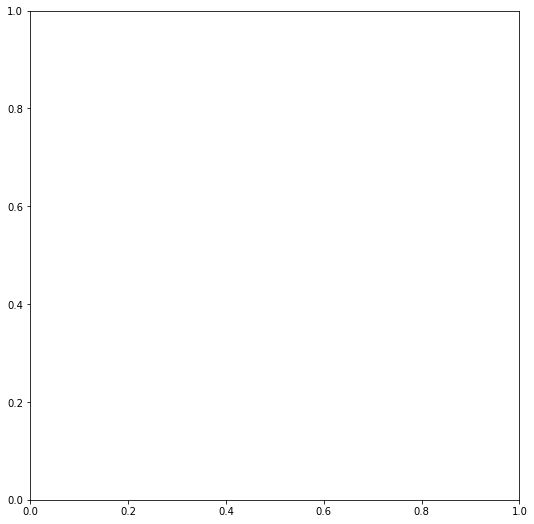

In [52]:
train_loader, valid_loader = prep_loaders(SPECIM, hyspec=False, batch_size=batch_size, workers=workers)
import torchvision
sample = iter(train_loader).next()
print(np.array(class_names)[sample['label'].unique()])
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['image'], padding=0,normalize=True).permute((1, 2, 0)))
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['label'], padding=0).permute((1, 2, 0))[:,:,0])

In [11]:
x = sample['image'].float().cuda()
mask = torch.argmax(model(x),dim=1).squeeze().cpu()[0]
imshow(mask)

NameError: name 'sample' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 2065.5, 259.5, -0.5)

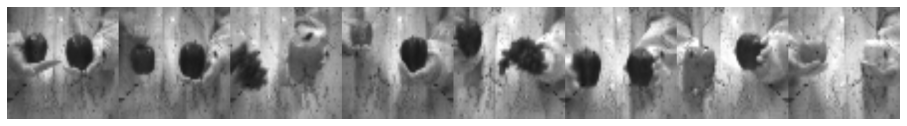

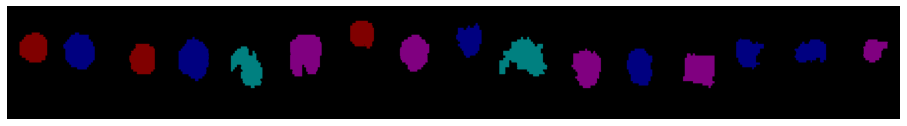

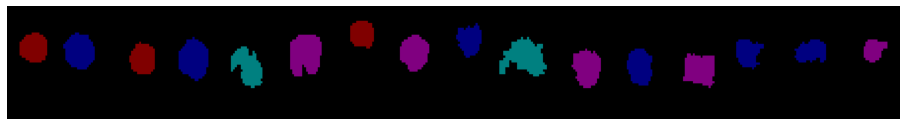

In [55]:
model.train()
def decode_segmap(mask, unk_label=255):
    """Decode segmentation label prediction as RGB images
    Args:
        mask (torch.tensor): class map with dimensions (B, M,N), where the value at
        a given location is the integer denoting the class index.
    Returns:
        (np.ndarray): colored image of shape (BM, BN, 3)
    """
    mask[mask == unk_label] == 0
    mask = mask.numpy()
    cmap = get_labels()
    cmap_exp = cmap[..., None]
    colored = cmap[mask].squeeze()
    grid = make_grid(torch.tensor(colored).permute(0, 3, 1, 2))
    return np.transpose(grid, (1, 2, 0))
#%pylab inline
mask = torch.argmax(model(x),dim=1).cpu()
figure(figsize=(16,16)); imshow(torchvision.utils.make_grid(sample['image'][:,:1,:,:], padding=0).permute((1, 2, 0)))
axis('off')
figure(figsize=(16,16)); imshow(decode_segmap(mask))
axis('off')
figure(figsize=(16,16)); imshow(decode_segmap(sample['label']))
axis('off')

In [49]:
metrics.reset()
for i, (sample) in enumerate(train_loader):
    if i>= 10:
        break
    x, y = sample['image'].float().cuda(), sample['label'].numpy()
    with torch.no_grad():
        y_pred = model(x)
        y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

    metrics.add_batch(y, y_pred.detach().cpu().numpy())

In [50]:
print('\nValidation stats ', metrics.get_table())


Validation stats                    IoU        F1      Prec    recall       Acc
bg,          0.997600  0.998700  0.998700  0.998900  0.997900
real apple   0.960600  0.979800  0.989000  0.971000  0.999200
real pepper  0.993500  0.996700  0.996000  0.997400  0.999900
real grape   0.978600  0.989100  0.988000  0.990400  0.999500
fake apple   0.988400  0.994100  0.992300  0.996000  0.999700
fake pepper  0.990400  0.995100  0.994400  0.996000  0.999800
fake grape   0.988600  0.994200  0.993400  0.995100  0.999600
total        0.985386  0.992529  0.993114  0.992114  0.999371
total(-bg)   0.983350  0.991500  0.992183  0.990983  0.999617


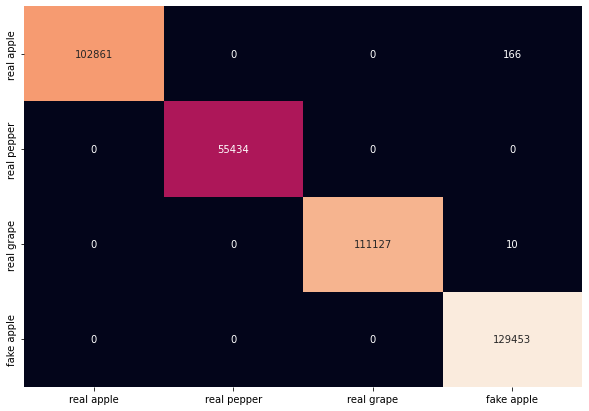

In [51]:
import seaborn as sn
df_cm = pd.DataFrame(metrics.confusion_matrix[1:-2,1:-2], index = [i for i in class_names[1:-2]],
                  columns = [i for i in class_names[1:-2]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.0f',cbar=False)
plt.show()
# plt.savefig('confusion_matrix_rgb.pdf',dpi=300)
# plt.close()

In [44]:
torch.save(model.state_dict(), 'epochs-%d' % epochs)

In [10]:
sample['image']

NameError: name 'sample' is not defined